Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from graphviz import Source
from mesfonctions import scatter_plot
from mesfonctions import arrondi
from mesfonctions import display_scores
from mesfonctions import barh_plot_coefs
from mesfonctions import affichage_tri_r2

from sklearn import set_config
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.tree import export_graphviz

In [2]:
# reload d'un élément du module mesfonctions après sa modification
import mesfonctions
from importlib import reload  
mesfonctions = reload(mesfonctions)

## Gestion des paramètres d'affichage de Jupyter

In [3]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 160 sur ma config portable
np.set_printoptions(linewidth=160)

# affichage des objets sklearn
set_config(display='diagram')

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

## Chargement du pickle du df nettoyé, contenant les PropertyUseTypeGFA

In [4]:
df_train = pd.read_pickle('df_train_avec_PropertyUseTypeGFA.pkl')
df_test = pd.read_pickle('df_test_avec_PropertyUseTypeGFA.pkl')

liste_modalites_types_1_2_3 = pickle.load(open('liste_modalites_types_1_2_3.pkl', 'rb'))
liste_variables_PropertyUseTypes_GFA = pickle.load(open('liste_variables_PropertyUseTypes_GFA.pkl', 'rb'))

# Première approche pour TotalGHGEmissions : utilisation des surfaces des PropertyUseType et calcul direct

## Séparation des variables explicatives et variable à prédire

##### Suppression des lignes pour lesquelles la variable 'TotalGHGEmissions' n'est pas renseignée

In [5]:
df_train = df_train.dropna(subset=['TotalGHGEmissions']).copy()
df_test = df_test.dropna(subset=['TotalGHGEmissions']).copy()
len(df_train)

1329

##### Variables explicatives :

In [6]:
X_train_GHG = df_train[liste_variables_PropertyUseTypes_GFA].copy()
X_test_GHG = df_test[liste_variables_PropertyUseTypes_GFA].copy()

##### Variable à prédire :

In [7]:
y_train_GHG = df_train[['TotalGHGEmissions']].copy()
y_test_GHG = df_test[['TotalGHGEmissions']].copy()

## Imputation, one-hot encoding, recalibrage

Imputation : non pertinent.  
One-hot encoding : non pertinent car toutes les variables sont quantitatives.  
Recalibrage : non pertinent, on part sur l'hypothèse que l'EnergyUse est proportionnel à la surface.  

## Dummy Regressor

In [8]:
moyenne = y_train_GHG.mean()
arrondi(moyenne)

[184]

In [9]:
ecart_type = y_train_GHG.std()
arrondi(ecart_type)

[734]

In [10]:
zipped = zip(["mean", "median", "quantile", "constant"], [None, None, 0.8, None], [None, None, None, moyenne])
for strategy, quantile, constant in zipped:
    print("Stratégie :", strategy, "/", quantile, constant)
    dum_reg = DummyRegressor(strategy=strategy, quantile=quantile, constant=constant)
    dum_reg.fit(X_train_GHG, y_train_GHG)
    GHG_predictions = dum_reg.predict(X_train_GHG)
    print("R² =", arrondi(r2_score(y_train_GHG, GHG_predictions)))
    print()

Stratégie : mean / None None
R² = 0

Stratégie : median / None None
R² = -0.034

Stratégie : quantile / 0.8 None
R² = -3.47e-07

Stratégie : constant / None TotalGHGEmissions    184.305847
dtype: float64
R² = 0



##### Cross validation

In [11]:
dum_reg = DummyRegressor(strategy='mean')
dum_scores = cross_val_score(dum_reg, X_train_GHG, y_train_GHG,
                             scoring="r2", cv=5)
display_scores(dum_scores, 2)

Scores: -0.00022 -0.0011 -0.00013 -0.00085 -0.00093 
Mean: -0.00065
Standard deviation: 0.00044


##### Prédiction sur y_test

In [12]:
dum_reg = DummyRegressor(strategy='mean')
dum_reg.fit(X_train_GHG, y_train_GHG)
print(arrondi(dum_reg.score(X_test_GHG, y_test_GHG), 5))

-6.5558e-05


## Régression linéaire simple

In [13]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_GHG, y_train_GHG)

LinearRegression()

In [14]:
# Test de quelques valeurs prédites
some_data = X_train_GHG.iloc[:100]
some_labels = y_train_GHG.iloc[:100].copy()
some_data_predicted = lin_reg.predict(some_data)

some_labels['Prédictions'] = some_data_predicted
some_labels

,TotalGHGEmissions,Prédictions
2447,2.35,12.996031
2559,55.06,-5.856768
137,272.85,458.242259
1969,21.50,27.011649
446,25.74,59.715190
1519,208.53,95.836583
3317,214.19,175.259488
1197,32.86,36.492032
530,119.46,249.046689
245,168.88,178.866399


### Metrics

##### RMSE :

In [15]:
GHG_predictions = lin_reg.predict(X_train_GHG)
lin_mse = mean_squared_error(y_train_GHG, GHG_predictions)
lin_rmse = np.sqrt(lin_mse)
arrondi(lin_rmse)

251

##### MAE :

In [16]:
lin_mae = mean_absolute_error(y_train_GHG, GHG_predictions)
arrondi(lin_mae)

102

##### R² :

In [17]:
lin_reg.score(X_train_GHG, y_train_GHG)

0.8830545297052184

### Cross validation

In [18]:
lin_scores = cross_val_score(lin_reg, X_train_GHG, y_train_GHG,
                             scoring="neg_root_mean_squared_error", cv=5)
display_scores(-lin_scores)

Scores: 481 344 745 708 244 
Mean: 504
Standard deviation: 220


In [19]:
lin_scores = cross_val_score(lin_reg, X_train_GHG, y_train_GHG,
                             scoring="r2", cv=5)
display_scores(lin_scores)
R2_nr_LR_cv = lin_scores.mean()

Scores: 0.575 0.406 0.495 0.124 0.781 
Mean: 0.476
Standard deviation: 0.241


##### Prise en main de make_scorer() utilisé dans le notebook suivant

In [20]:
# def my_custom_score_func(Z_true, Z_pred):
#     score = r2_score(Z_true, Z_pred)
#     print("R² score = ", score)
    
#     df = Z_true.copy()
#     df["Prédictions"] = Z_pred
#     display(df.head(200))
    
#     print("------------------")
    
#     return score

In [21]:
# my_scorer = make_scorer(my_custom_score_func)

In [22]:
# lin_scores = cross_val_score(lin_reg, X_train_GHG, y_train_GHG,
#                              scoring=my_scorer, cv=5)
# display_scores(lin_scores)

### Généralisation du modèle sur y_test

In [23]:
GHG_predictions = lin_reg.predict(X_test_GHG)
R2_nr_LR_pred = r2_score(y_test_GHG, GHG_predictions)
arrondi(R2_nr_LR_pred)

0.888

##### Scatter plot

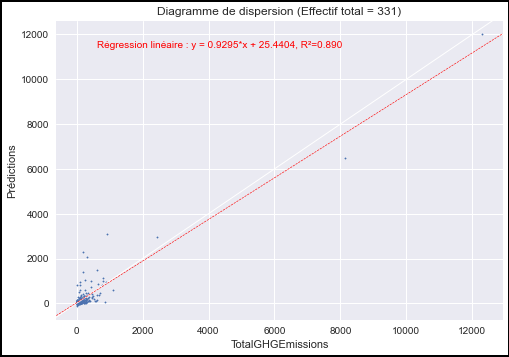

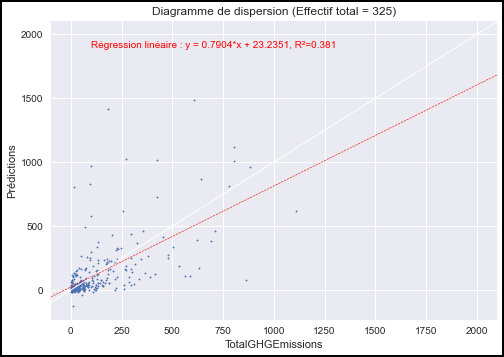

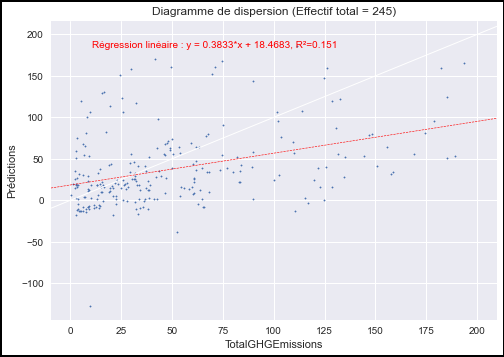

In [24]:
ser_predictions = pd.Series(np.squeeze(GHG_predictions), name='Prédictions')
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, droite_identite=True)
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=2000, max_y=2000, droite_identite=True)
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=200, max_y=200, droite_identite=True)

### Analyse des paramètres du modèle

In [25]:
arrondi(lin_reg.intercept_)

[-25.6]

In [26]:
print("lin_reg.coef_ shape :", lin_reg.coef_.shape)
coefs = lin_reg.coef_

lin_reg.coef_ shape : (1, 64)


In [27]:
coefs

array([[ 6.27757301e-04,  1.98638227e-03,  1.31518266e-03,  1.04462451e-03,  4.11716146e-03,  3.02131614e-03,  1.86678766e-03,  1.22393059e-03,
         4.15653391e-03,  2.93041145e-03, -2.03495951e-04,  7.86339257e-04,  1.45872209e-03,  1.24368716e-03,  4.28671133e-03,  8.29486696e-04,
         1.30275002e-03,  1.90627982e-02, -2.24040958e-03,  5.16505217e-04,  5.81756627e-03,  9.15323302e-03,  7.39153828e-03,  5.80586145e-03,
         1.28167298e-03,  6.66557650e-03, -1.41779591e-03,  2.66218034e-03,  4.72477768e-03,  8.91733797e-03,  2.23052125e-03,  2.01688302e-03,
         6.10383181e-06,  1.20128163e-03, -3.16196544e-04,  2.96750065e-03,  7.47624288e-03,  7.77236685e-03,  1.48218856e-03,  1.90402338e-02,
        -1.18668377e-04,  4.13425779e-03,  9.25064116e-03,  2.50910939e-03,  3.25902526e-03,  1.85305963e-03,  3.95166670e-03,  2.86633963e-03,
         1.62352384e-03,  3.68571877e-03,  1.81647786e-03,  4.78065449e-03,  4.39138928e-03,  2.40320655e-03, -2.42861287e-17,  9.842185

In [28]:
liste_effectif = []
for moda in liste_modalites_types_1_2_3:
    effectif = len(df_train[moda+' GFA'][df_train[moda+' GFA']!=0])
    liste_effectif.append(effectif)
df_coefs = pd.DataFrame(liste_effectif, columns=['Effectif'], index=liste_modalites_types_1_2_3)

In [29]:
df_coefs['Coef NR LR'] = coefs.T
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef NR LR', ascending=False))

,Effectif,Coef NR LR
Other - Technology/Science,1,8.9e-02
Laboratory,21,1.9e-02
Other/Specialty Hospital,3,1.9e-02
Food Sales,2,1.4e-02
Bar/Nightclub,4,9.8e-03
Other - Restaurant/Bar,6,9.3e-03
Social/Meeting Hall,17,9.2e-03
Other - Education,7,8.9e-03
Urgent Care/Clinic/Other Outpatient,2,7.8e-03
Data Center,20,7.5e-03


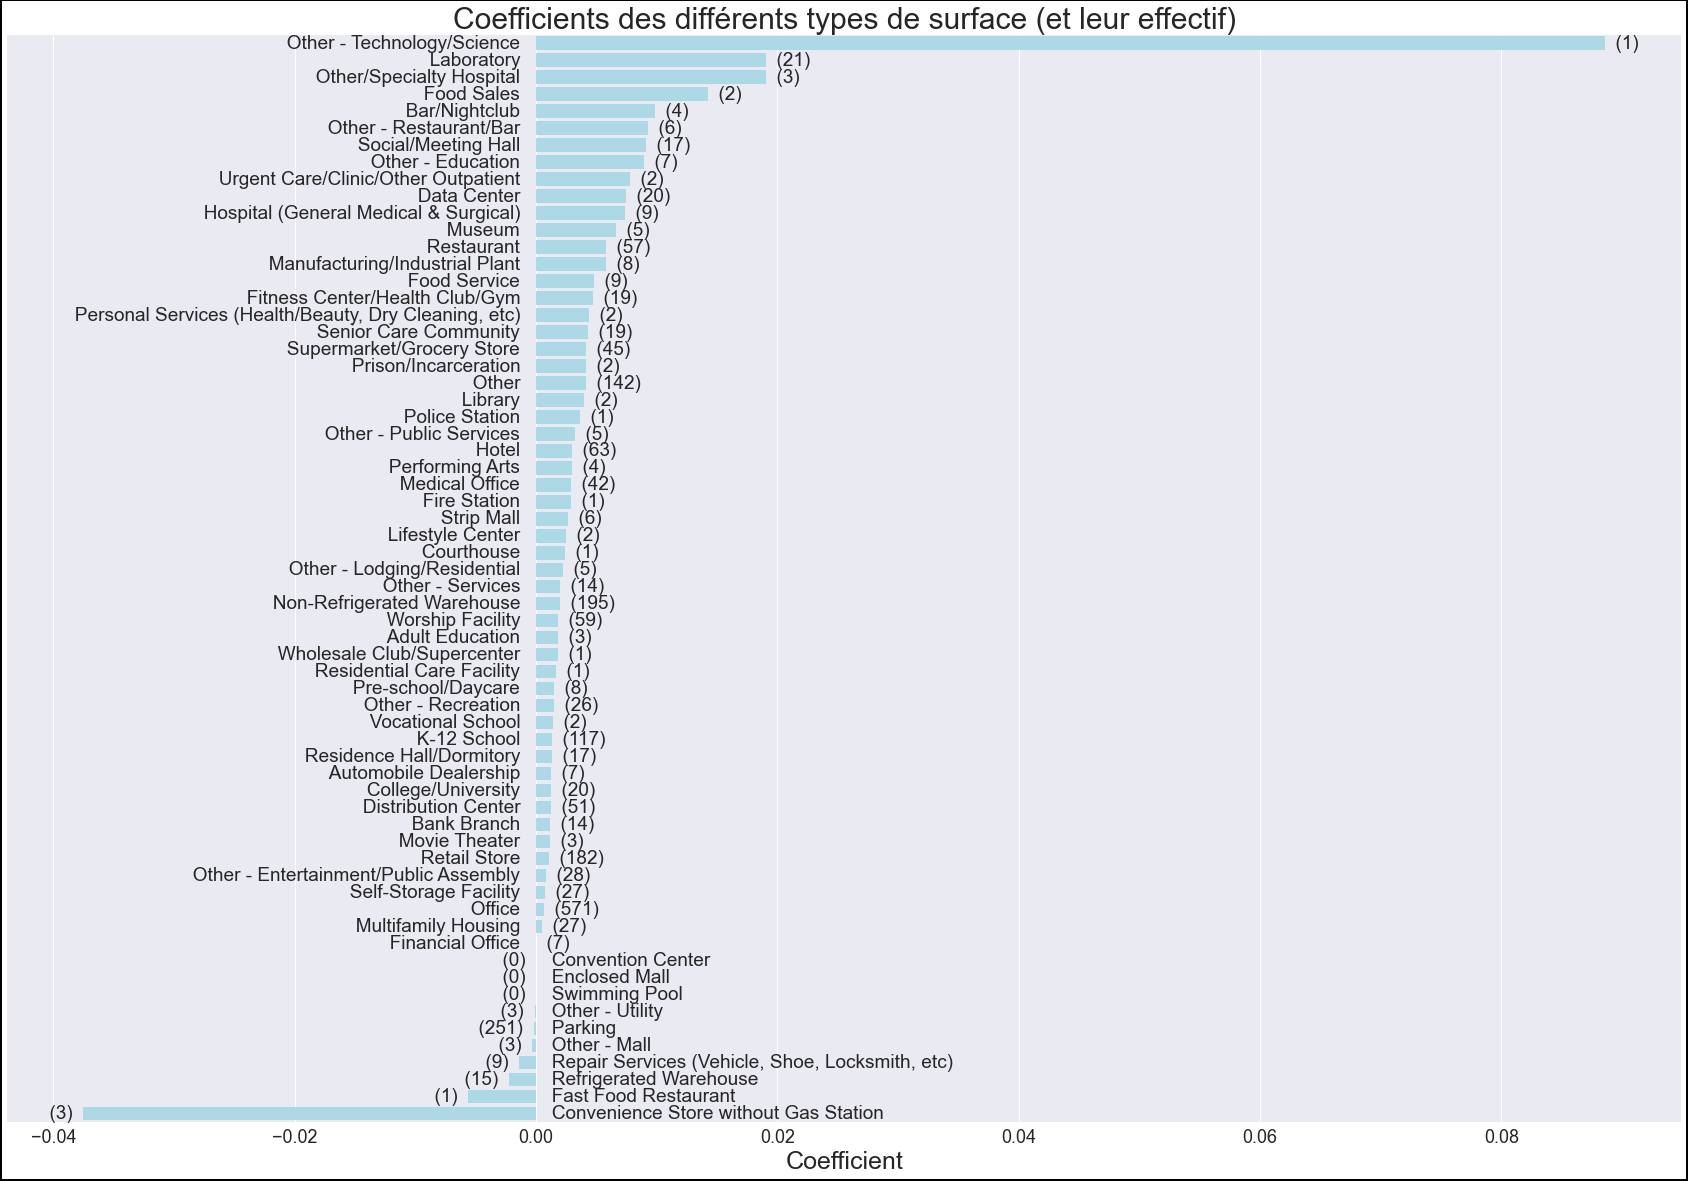

In [30]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef NR LR', ascending=True).iloc[:, 1], effectif_array=df_coefs.sort_values(by='Coef NR LR', ascending=True).iloc[:, 0])

## Recalibrage des variables

### Transformation = StandardScaler

In [31]:
ss = StandardScaler()
X_train_GHG_ss = ss.fit_transform(X_train_GHG)
X_test_GHG_ss = ss.transform(X_test_GHG)

## Ridge regression

### Variables non recalibrées

In [32]:
ridge_nr = RidgeCV(alphas=np.logspace(10, 14, 100), cv=5)   
ridge_nr.fit(X_train_GHG, y_train_GHG)

RidgeCV(alphas=array([1.00000000e+10, 1.09749877e+10, 1.20450354e+10, 1.32194115e+10, 1.45082878e+10, 1.59228279e+10, 1.74752840e+10, 1.91791026e+10, 2.10490414e+10,
       2.31012970e+10, 2.53536449e+10, 2.78255940e+10, 3.05385551e+10, 3.35160265e+10, 3.67837977e+10, 4.03701726e+10, 4.43062146e+10, 4.86260158e+10,
       5.33669923e+10, 5.85702082e+10, 6.42807312e+10, 7.05480231e+1...
       8.11130831e+12, 8.90215085e+12, 9.77009957e+12, 1.07226722e+13, 1.17681195e+13, 1.29154967e+13, 1.41747416e+13, 1.55567614e+13, 1.70735265e+13,
       1.87381742e+13, 2.05651231e+13, 2.25701972e+13, 2.47707636e+13, 2.71858824e+13, 2.98364724e+13, 3.27454916e+13, 3.59381366e+13, 3.94420606e+13,
       4.32876128e+13, 4.75081016e+13, 5.21400829e+13, 5.72236766e+13, 6.28029144e+13, 6.89261210e+13, 7.56463328e+13, 8.30217568e+13, 9.11162756e+13,
       1.00000000e+14]),
        cv=5)

In [33]:
best_alpha = ridge_nr.alpha_
arrondi(best_alpha, puissance10=9)

'376.49e9'

In [34]:
# R²
R2_nr_ridge_cv = ridge_nr.best_score_
arrondi(R2_nr_ridge_cv)

0.575

##### Prédiction sur y_test

In [35]:
ridge_nr = Ridge(alpha=best_alpha)
ridge_nr.fit(X_train_GHG, y_train_GHG)
R2_nr_ridge_pred = arrondi(ridge_nr.score(X_test_GHG, y_test_GHG))
print(R2_nr_ridge_pred)

0.931


#### Analyse des paramètres du modèle

In [36]:
arrondi(ridge_nr.intercept_)

[36.0]

In [37]:
print("ridge_nr.coef_ shape :", ridge_nr.coef_.shape)
coefs = ridge_nr.coef_

ridge_nr.coef_ shape : (1, 64)


In [38]:
coefs

array([[ 6.10614020e-04,  2.35204086e-03,  6.38737178e-04,  4.83387563e-04,  2.79607105e-03,  2.40000306e-03,  1.05811269e-04,  2.01636385e-04,
         7.63173673e-04,  2.07988738e-03,  3.20163730e-04, -3.79963351e-05,  6.24485037e-04,  1.22591829e-03,  1.49058871e-03,  7.17752166e-04,
         2.52036768e-04,  1.14543697e-02, -6.74911733e-04,  4.83461916e-05,  2.40423213e-04,  1.42740649e-04,  6.54571907e-03,  3.75378936e-05,
        -1.35899988e-05,  1.16186355e-04, -1.08172622e-05,  1.90568565e-04,  1.20643103e-04,  7.86210648e-05,  6.20892831e-06,  3.45533027e-05,
        -1.93218830e-04, -1.33932181e-05,  1.73177833e-04,  2.20668803e-05,  1.02899398e-03,  4.84654588e-04, -3.48417525e-06,  3.33474048e-04,
        -1.09655652e-05, -8.62135853e-07,  2.92364881e-05,  5.21068103e-04,  2.59223537e-05,  6.01112177e-06, -2.24296407e-07,  5.14796916e-06,
        -1.36509615e-06,  6.14174838e-05,  7.33417494e-05,  1.52813908e-06,  5.07732250e-06,  9.92880460e-04,  0.00000000e+00,  4.108091

In [39]:
df_coefs['Coef NR Ridge'] = coefs.T
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef NR Ridge', ascending=False))

,Effectif,Coef NR LR,Coef NR Ridge
Laboratory,21,1.9e-02,1.1e-02
Hospital (General Medical & Surgical),9,7.4e-03,6.5e-03
Other,142,4.1e-03,2.8e-03
Hotel,63,3.0e-03,2.4e-03
Non-Refrigerated Warehouse,195,2.0e-03,2.4e-03
Medical Office,42,2.9e-03,2.1e-03
Senior Care Community,19,4.3e-03,1.5e-03
College/University,20,1.2e-03,1.2e-03
Data Center,20,7.5e-03,1.0e-03
Courthouse,1,2.4e-03,9.9e-04


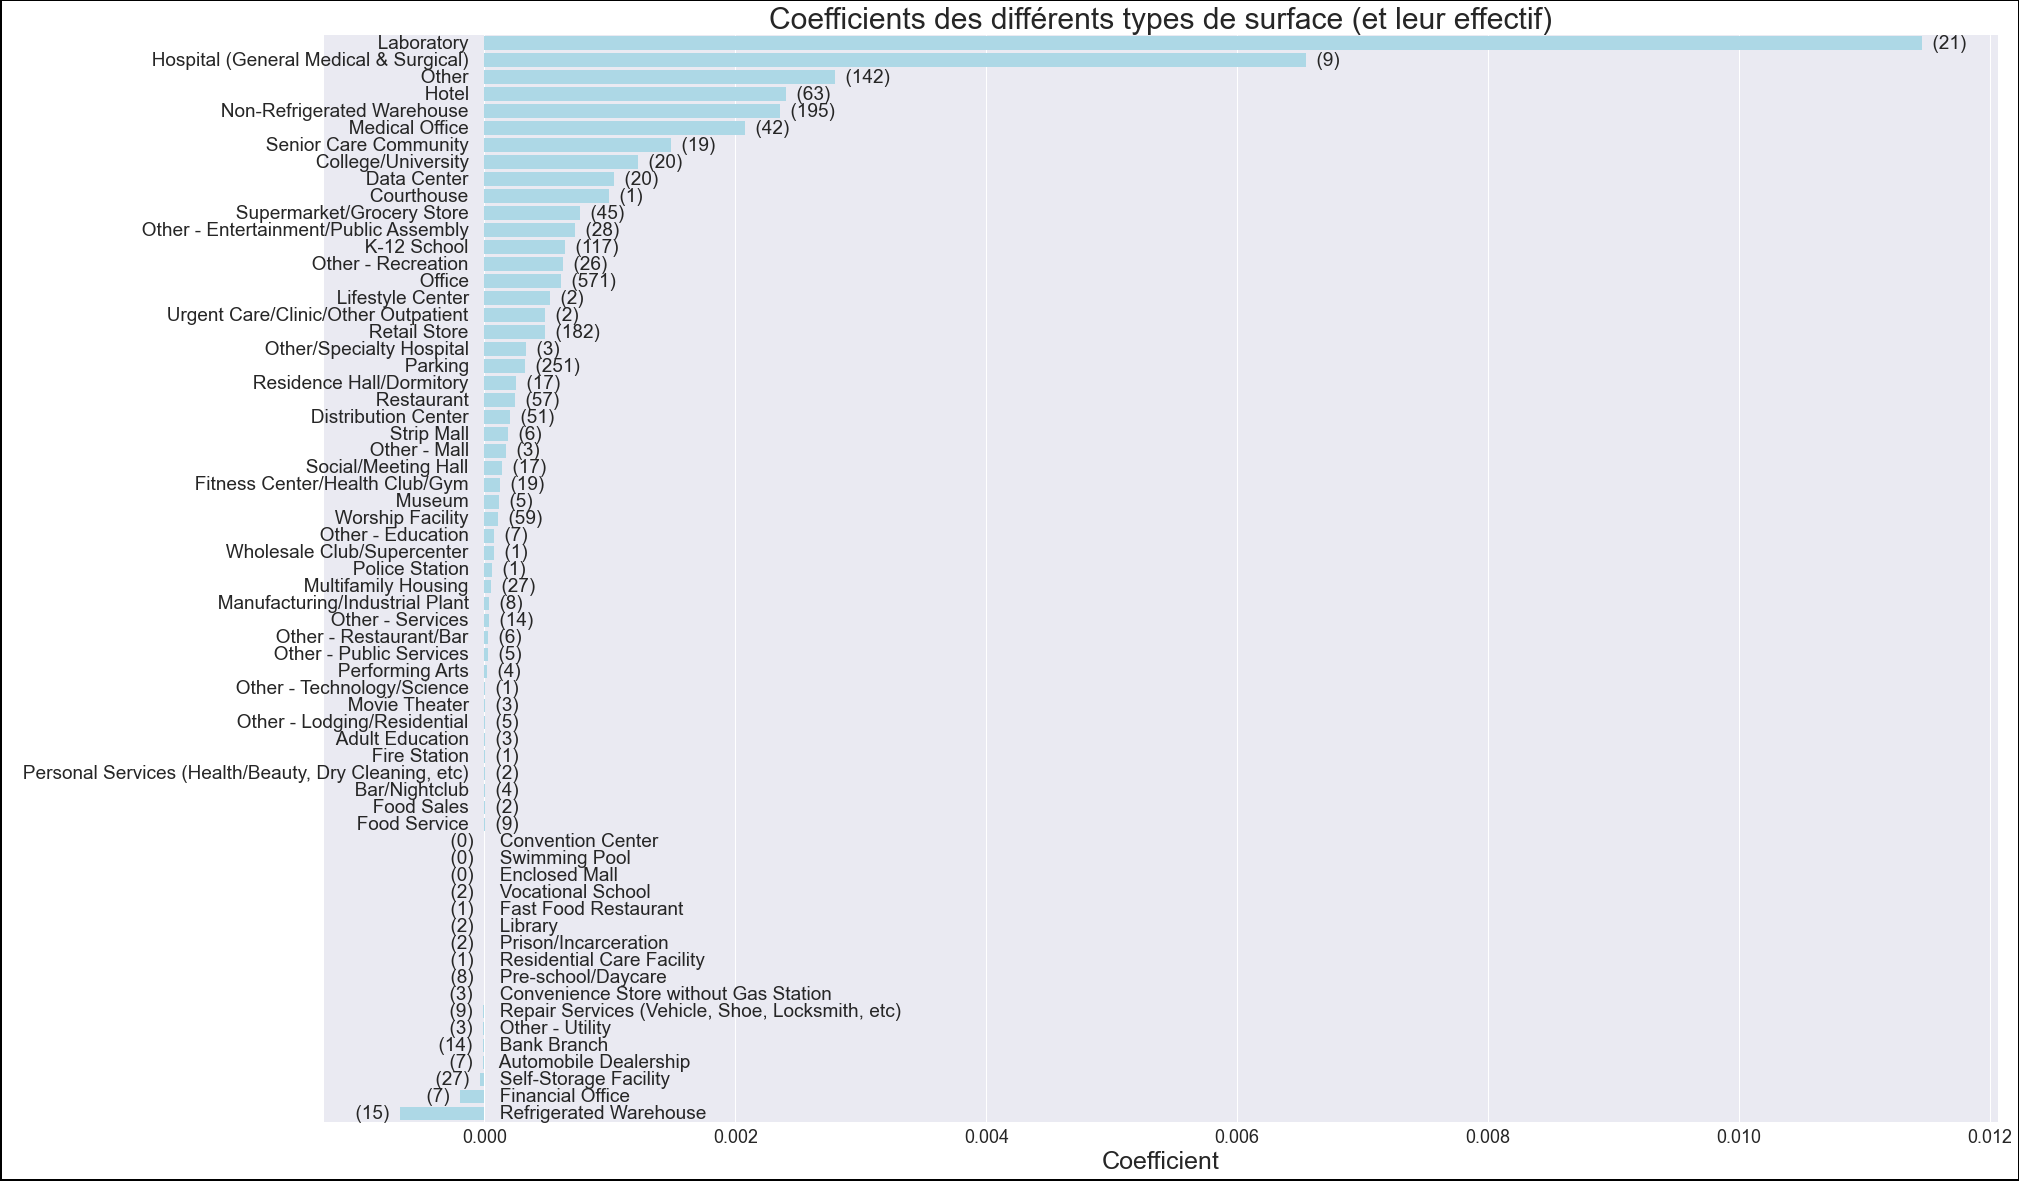

In [40]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef NR Ridge', ascending=True).loc[:, 'Coef NR Ridge'], effectif_array=df_coefs.sort_values(by='Coef NR Ridge', ascending=True).iloc[:, 0])

### Recalibrage par StandardScaler ; RidgeCV classique

#### Cross validation

In [41]:
ridge_ss = RidgeCV(alphas=np.logspace(0, 4, 100), cv=5)    # 100 valeurs alpha entre 1e0 et 1e2
ridge_ss.fit(X_train_GHG_ss, y_train_GHG)

RidgeCV(alphas=array([1.00000000e+00, 1.09749877e+00, 1.20450354e+00, 1.32194115e+00, 1.45082878e+00, 1.59228279e+00, 1.74752840e+00, 1.91791026e+00, 2.10490414e+00,
       2.31012970e+00, 2.53536449e+00, 2.78255940e+00, 3.05385551e+00, 3.35160265e+00, 3.67837977e+00, 4.03701726e+00, 4.43062146e+00, 4.86260158e+00,
       5.33669923e+00, 5.85702082e+00, 6.42807312e+00, 7.05480231e+0...
       8.11130831e+02, 8.90215085e+02, 9.77009957e+02, 1.07226722e+03, 1.17681195e+03, 1.29154967e+03, 1.41747416e+03, 1.55567614e+03, 1.70735265e+03,
       1.87381742e+03, 2.05651231e+03, 2.25701972e+03, 2.47707636e+03, 2.71858824e+03, 2.98364724e+03, 3.27454916e+03, 3.59381366e+03, 3.94420606e+03,
       4.32876128e+03, 4.75081016e+03, 5.21400829e+03, 5.72236766e+03, 6.28029144e+03, 6.89261210e+03, 7.56463328e+03, 8.30217568e+03, 9.11162756e+03,
       1.00000000e+04]),
        cv=5)

In [42]:
best_alpha = ridge_ss.alpha_
best_alpha

45.34878508128585

In [43]:
# R²
R2_ss_ridge_cv = ridge_ss.best_score_
arrondi(R2_ss_ridge_cv)

0.667

#### Analyse des paramètres du modèle

In [44]:
arrondi(float(ridge_ss.intercept_))

184

In [45]:
print(ridge_ss.coef_.shape)
ridge_ss.coef_

(1, 64)


array([[ 6.71188014e+01,  6.79323169e+01,  3.48268062e+01,  2.56329876e+01,  1.11896205e+02,  1.16300287e+02,  1.25255529e+01,  1.50204170e+01,
         3.61189046e+01,  6.06092302e+01,  1.79320527e+00,  4.23611987e+00,  2.21619256e+01,  3.13923926e+02,  5.43480039e+01,  4.35855928e+01,
         1.31742402e+01,  3.91282216e+02, -1.96929661e+01,  5.01059297e+00,  2.34100640e+01,  2.00849223e+01,  3.71440160e+02,  9.21629660e+00,
         3.61074799e+00,  1.56828826e+01, -3.62349835e+00,  1.32306088e+01,  1.47131830e+01,  1.44685748e+01,  3.47496587e+00,  7.11453311e+00,
        -6.66991844e-01,  6.49341998e-01, -4.01584411e+00,  5.40331005e+00,  5.05946271e+01,  3.34040408e+01,  1.98629616e+00,  4.03328070e+01,
        -5.34547662e-01,  1.46164575e+00,  1.00589590e+01,  2.17275362e+01,  5.69844608e+00,  3.15230403e+00,  1.76152960e+00,  2.73417997e+00,
         8.74857303e-01,  8.45613148e+00,  6.74795169e+00,  3.53179503e+00,  2.96796251e+00,  3.40040523e+01,  0.00000000e+00,  4.137773

In [46]:
df_coefs['Coef SS Ridge'] = ridge_ss.coef_.T

In [47]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef SS Ridge', ascending=False))

,Effectif,Coef NR LR,Coef NR Ridge,Coef SS Ridge
Laboratory,21,1.9e-02,1.1e-02,391.3
Hospital (General Medical & Surgical),9,7.4e-03,6.5e-03,371.4
College/University,20,1.2e-03,1.2e-03,313.9
Hotel,63,3.0e-03,2.4e-03,116.3
Other,142,4.1e-03,2.8e-03,111.9
Non-Refrigerated Warehouse,195,2.0e-03,2.4e-03,67.9
Office,571,6.3e-04,6.1e-04,67.1
Medical Office,42,2.9e-03,2.1e-03,60.6
Senior Care Community,19,4.3e-03,1.5e-03,54.3
Data Center,20,7.5e-03,1.0e-03,50.6


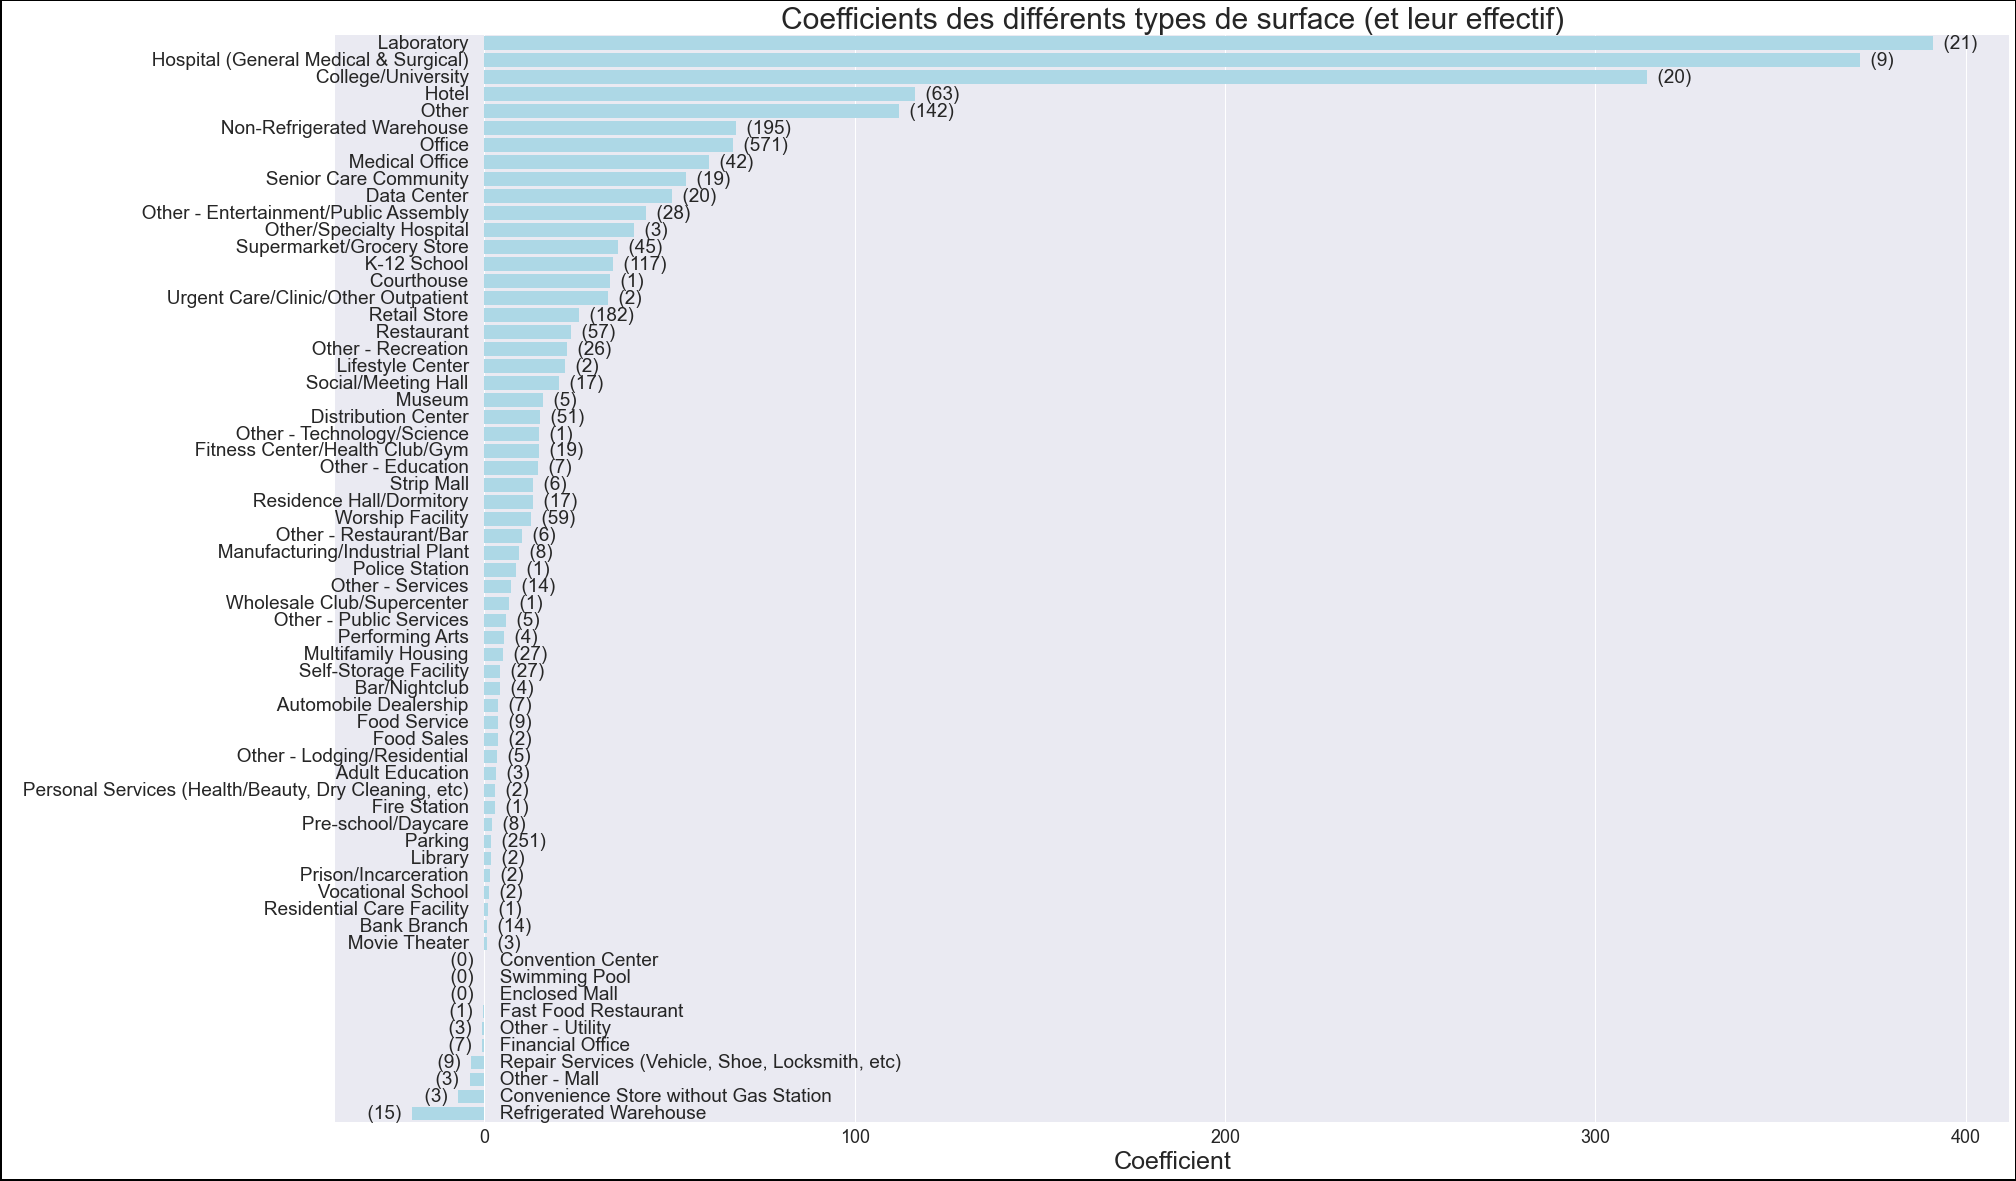

In [48]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Ridge', ascending=True).loc[:, 'Coef SS Ridge'], effectif_array=df_coefs.sort_values(by='Coef SS Ridge', ascending=True).iloc[:, 0])

##### Prédiction sur y_test

In [49]:
ridge_ss = Ridge(alpha=best_alpha)
ridge_ss.fit(X_train_GHG_ss, y_train_GHG)
R2_ss_ridge_pred = arrondi(ridge_ss.score(X_test_GHG_ss, y_test_GHG))
print(R2_ss_ridge_pred)

0.894


#### Faire une validation croisée "à la main" pour mieux maitriser le fonctionnement interne d'une fonction "tout-en-un" comme RidgeCV :

In [50]:
ridge_ss_test = Ridge(alpha=best_alpha) 
scores = cross_val_score(ridge_ss_test, X_train_GHG_ss, y_train_GHG, 
                         scoring="r2", cv=5)
display_scores(scores)

Scores: 0.811 0.423 0.449 0.853 0.8 
Mean: 0.667
Standard deviation: 0.212


L'écart-type plutôt élevé est préoccupant ; il traduit un problème lié aux folds.  

#### Plot du R² en fonction du nb de folds

In [51]:
liste_cv = []
liste_mean = []
liste_std = []
for i in range(2, 35):
    ridge_ss_test = Ridge(alpha=best_alpha) 
    scores = cross_val_score(ridge_ss_test, X_train_GHG_ss, y_train_GHG, 
                             scoring="r2", cv=i)
    liste_cv.append(i)
    liste_mean.append(scores.mean())
    liste_std.append(scores.std(ddof=1))

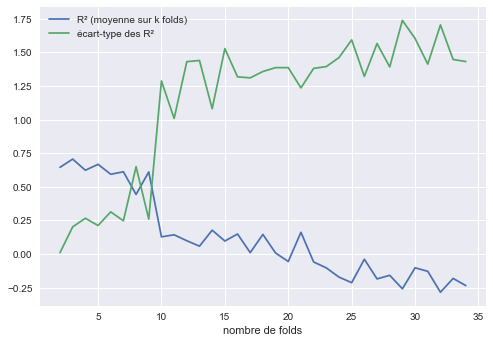

In [52]:
plt.plot(liste_cv, liste_mean)
plt.plot(liste_cv, liste_std)
plt.xlabel('nombre de folds')
plt.legend(['R² (moyenne sur k folds)', 'écart-type des R²']);

La taille du dataset est trop petite pour envisager un nombre de folds trop important.  

#### Plot du R² en fonction de alpha

In [53]:
# calcul de la baseline_R2   (idem R2_nr_LR_cv)
lin_scores = cross_val_score(lin_reg, X_train_GHG, y_train_GHG,
                             scoring="r2", cv=5)
baseline_R2 = lin_scores.mean()
arrondi(baseline_R2)

0.476

In [54]:
# calcul des R² pour chaque alpha
liste_alpha = np.logspace(-2, 7, 100)   # 100 valeurs alpha entre 1e-1 et 1e2
liste_R2 = []
liste_baseline = []
for alpha in liste_alpha:  
    ridge_ss_test = Ridge(alpha=alpha) 
    scores = cross_val_score(ridge_ss_test, X_train_GHG_ss, y_train_GHG, 
                             scoring="r2", cv=5)
    liste_R2.append(scores.mean())
    liste_baseline.append(baseline_R2)

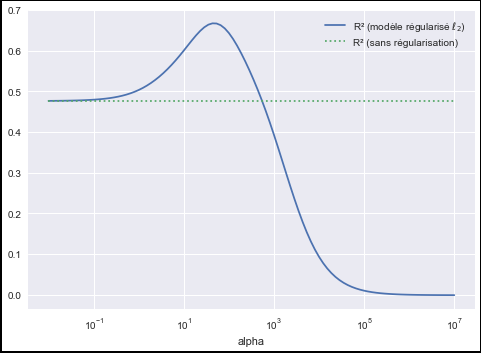

In [55]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_2$'+')', 'R² (sans régularisation)'])
plt.show()

### Recalibrage par StandardScaler ; RidgeCV LOO (cv=None (use the Leave-One-Out cross-validation))

In [56]:
ridge_ss_LOO = RidgeCV(alphas=np.logspace(0, 2, 100), cv=None)
ridge_ss_LOO.fit(X_train_GHG_ss, y_train_GHG);

In [57]:
ridge_ss_LOO.alpha_

45.34878508128585

In [58]:
# root mean squared error 
R2_ss_ridge_cv_LOO = arrondi(-ridge_ss_LOO.best_score_, 5)   # lorsque cv=None, best_score_ retourne negMSE
print("RMSE =", arrondi(np.sqrt(R2_ss_ridge_cv_LOO)))

RMSE = 439


C'est mauvais en apparence (RMSE = 251 pour modèle linéaire CV), mais je n'ai pas de LOO pour comparer toutes choses égales par ailleurs.

##### Prédiction sur y_test

In [59]:
ridge_ss_LOO = Ridge(alpha=best_alpha)
ridge_ss_LOO.fit(X_train_GHG_ss, y_train_GHG)
print(arrondi(ridge_ss_LOO.score(X_test_GHG_ss, y_test_GHG), 5))

0.89382


## Régression LASSO (variables recalibrées par StandardScaler)

### Fonction LassoCV

In [60]:
lasso_ss = LassoCV(alphas=np.logspace(-1, 3, 100), cv=5, tol=1e-10) 
lasso_ss.fit(X_train_GHG_ss, y_train_GHG.iloc[:,0])

LassoCV(alphas=array([1.00000000e-01, 1.09749877e-01, 1.20450354e-01, 1.32194115e-01, 1.45082878e-01, 1.59228279e-01, 1.74752840e-01, 1.91791026e-01, 2.10490414e-01,
       2.31012970e-01, 2.53536449e-01, 2.78255940e-01, 3.05385551e-01, 3.35160265e-01, 3.67837977e-01, 4.03701726e-01, 4.43062146e-01, 4.86260158e-01,
       5.33669923e-01, 5.85702082e-01, 6.42807312e-01, 7.05480231e-0...
       8.11130831e+01, 8.90215085e+01, 9.77009957e+01, 1.07226722e+02, 1.17681195e+02, 1.29154967e+02, 1.41747416e+02, 1.55567614e+02, 1.70735265e+02,
       1.87381742e+02, 2.05651231e+02, 2.25701972e+02, 2.47707636e+02, 2.71858824e+02, 2.98364724e+02, 3.27454916e+02, 3.59381366e+02, 3.94420606e+02,
       4.32876128e+02, 4.75081016e+02, 5.21400829e+02, 5.72236766e+02, 6.28029144e+02, 6.89261210e+02, 7.56463328e+02, 8.30217568e+02, 9.11162756e+02,
       1.00000000e+03]),
        cv=5, tol=1e-10)

In [61]:
lasso_ss.alpha_

9.545484566618342

In [62]:
lasso_ss.n_iter_

20

In [63]:
arrondi(lasso_ss.intercept_)

184

### Plot du R² en fonction de alpha (fonction Lasso)

In [64]:
# calcul des R² pour chaque alpha
liste_alpha = np.logspace(-3, 4, 300)   # 300 valeurs alpha
liste_R2 = []
liste_baseline = []
for alpha in liste_alpha:  
    lasso_ss = Lasso(alpha=alpha) 
    scores = cross_val_score(lasso_ss, X_train_GHG_ss, y_train_GHG, 
                             scoring="r2", cv=5)
    liste_R2.append(scores.mean())
    liste_baseline.append(baseline_R2)

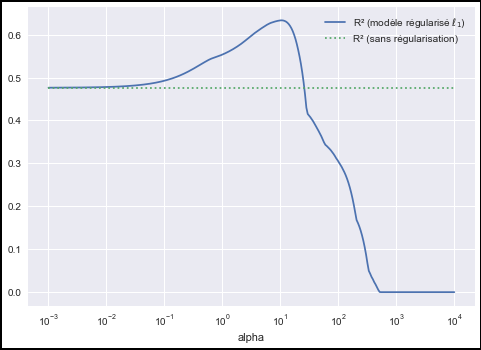

In [65]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_1$'+')', 'R² (sans régularisation)']);

In [66]:
indice_du_maxi = liste_R2.index(max(liste_R2))
print("Valeur optimale de alpha =", liste_alpha[indice_du_maxi])
R2_ss_lasso_cv = arrondi(liste_R2[indice_du_maxi])
print("Valeur optimale de R² =", R2_ss_lasso_cv)

Valeur optimale de alpha = 10.635449574860113
Valeur optimale de R² = 0.634


In [67]:
lasso_optimum = Lasso(alpha=liste_alpha[indice_du_maxi]) 
lasso_optimum.fit(X_train_GHG_ss, y_train_GHG)

Lasso(alpha=10.635449574860113)

In [68]:
arrondi(float(lasso_optimum.intercept_))

184

In [69]:
lasso_optimum.coef_

array([ 5.41613131e+01,  4.32179318e+01,  1.65238094e+01,  1.33679348e+01,  1.00021240e+02,  1.05954353e+02,  0.00000000e+00,  0.00000000e+00,  2.12860311e+01,
        5.15637539e+01,  0.00000000e+00, -0.00000000e+00,  1.07722054e+01,  3.12327815e+02,  4.19184310e+01,  3.26780641e+01,  0.00000000e+00,  4.00482844e+02,
       -2.34408575e-01,  0.00000000e+00,  1.07798267e+01,  7.78234384e+00,  3.71255853e+02,  0.00000000e+00,  0.00000000e+00,  3.37193036e+00, -0.00000000e+00,
        1.09356654e+00,  1.96227260e+00,  3.76633349e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.00780210e+01,  2.25016127e+01,  0.00000000e+00,  3.32564050e+01, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  1.06345177e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.33637487e+01,
        0.00000000e+00,  0.00000000e+00,

Le lasso met un grand nombre de coefficients à 0.

In [70]:
df_coefs['Coef SS Lasso'] = lasso_optimum.coef_.T

In [71]:
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coef SS Lasso', ascending=False))

,Effectif,Coef NR LR,Coef NR Ridge,Coef SS Ridge,Coef SS Lasso
Laboratory,21,1.9e-02,1.1e-02,391.3,400.5
Hospital (General Medical & Surgical),9,7.4e-03,6.5e-03,371.4,371.3
College/University,20,1.2e-03,1.2e-03,313.9,312.3
Hotel,63,3.0e-03,2.4e-03,116.3,106.0
Other,142,4.1e-03,2.8e-03,111.9,100.0
Office,571,6.3e-04,6.1e-04,67.1,54.2
Medical Office,42,2.9e-03,2.1e-03,60.6,51.6
Non-Refrigerated Warehouse,195,2.0e-03,2.4e-03,67.9,43.2
Senior Care Community,19,4.3e-03,1.5e-03,54.3,41.9
Data Center,20,7.5e-03,1.0e-03,50.6,40.1


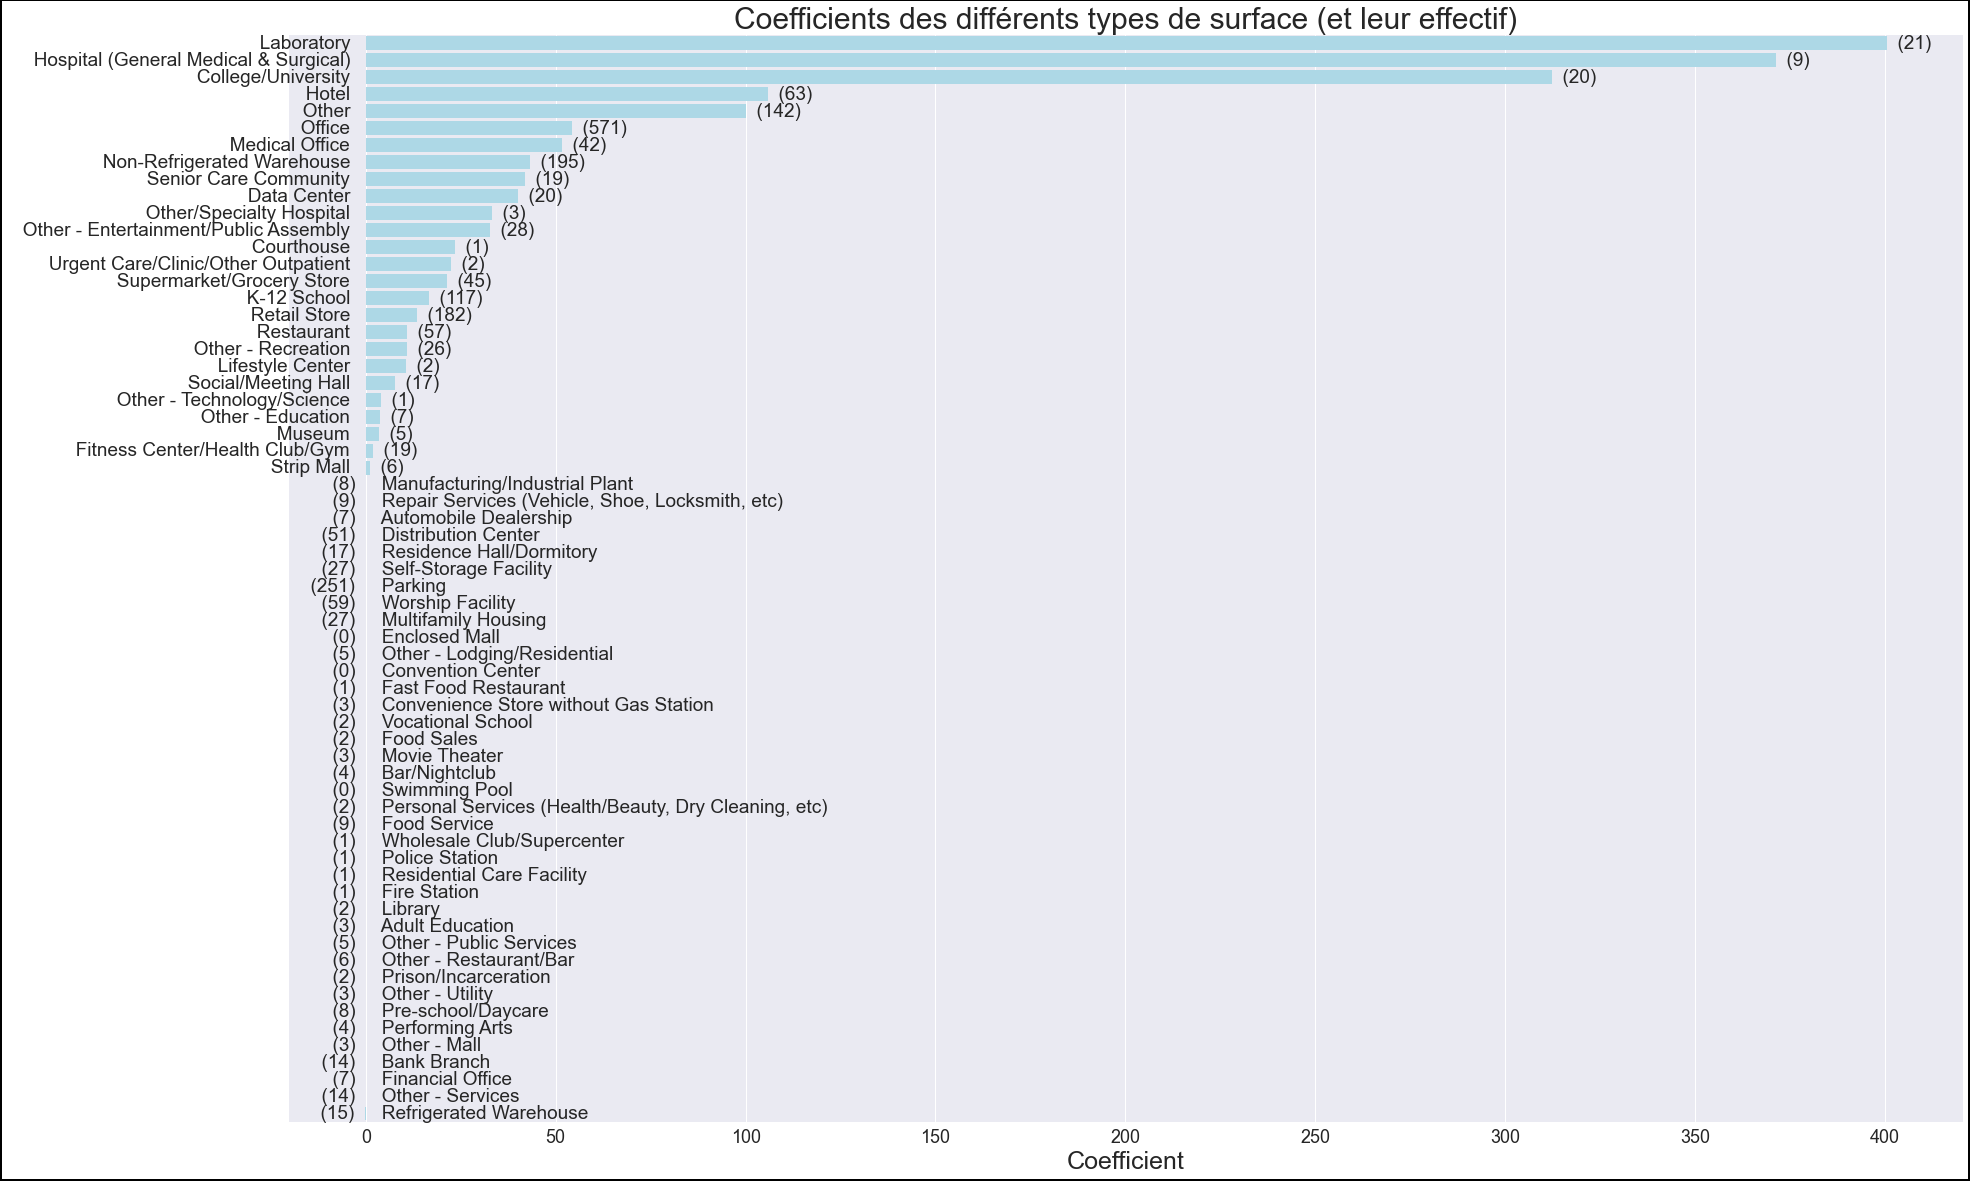

In [72]:
barh_plot_coefs(x_array = df_coefs.sort_values(by='Coef SS Lasso', ascending=True).loc[:, 'Coef SS Lasso'], effectif_array=df_coefs.sort_values(by='Coef SS Lasso', ascending=True).iloc[:, 0])

##### Prédiction sur y_test

In [73]:
lasso_optimum.fit(X_train_GHG_ss, y_train_GHG)
R2_ss_lasso_pred = lasso_optimum.score(X_test_GHG_ss, y_test_GHG)
print(arrondi(R2_ss_lasso_pred))

0.919


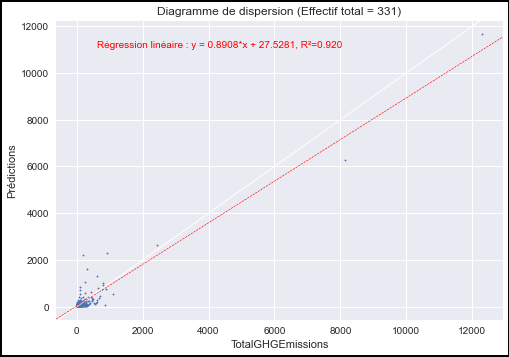

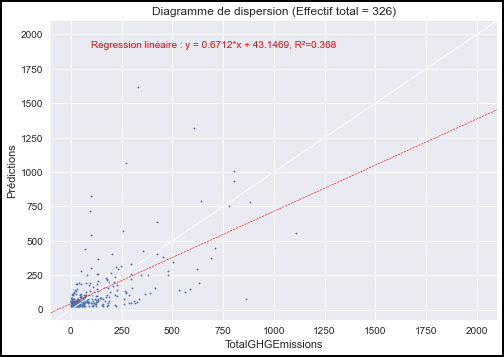

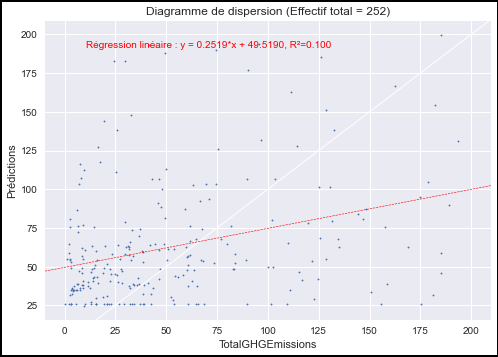

In [74]:
GHG_predictions = lasso_optimum.predict(X_test_GHG_ss)
ser_predictions = pd.Series(np.squeeze(GHG_predictions), name='Prédictions')
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, droite_identite=True)
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=2000, max_y=2000, droite_identite=True)
scatter_plot(ser_x=y_test_GHG.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=200, max_y=200, droite_identite=True)

## Bilan intermédiaire sur les modèles linéaires

### Résultats des cross-validations des modèles linéaires sur le training set

Les scores de CV sur le training sont les suivants :  
- R² = {{arrondi(R2_nr_LR_cv)}} (regression linéaire simple, sans recalibrage des data).
- R² = {{arrondi(R2_nr_ridge_cv)}} Ridge sans recalibrage.
- **R² = {{arrondi(R2_ss_ridge_cv)}} Ridge avec recalibrage StandardScaler.**
- R² = {{R2_ss_lasso_cv}} Lasso avec recalibrage StandardScaler.

### Résultats des généralisations des modèles linéaires sur le testing set

Après généralisation sur le testing set, les scores obtenus sont : 
- R² = {{arrondi(R2_nr_LR_pred)}} (regression linéaire simple, sans recalibrage des data).
- R² = {{arrondi(R2_nr_ridge_pred)}} (Ridge sans recalibrage).
- R² = {{arrondi(R2_ss_ridge_pred)}} (Ridge avec recalibrage StandardScaler).
- R² = {{arrondi(R2_ss_lasso_pred)}} (Lasso avec recalibrage StandardScaler).

## Arbres de décision (DecisionTreeRegressor)

In [75]:
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_GHG, y_train_GHG)

DecisionTreeRegressor(random_state=0)

In [76]:
df_feature_importances = pd.Series(tree_reg.feature_importances_, index=liste_modalites_types_1_2_3)
df_feature_importances.sort_values(ascending=False).head(100)

Laboratory                                              4.085966e-01
Hospital (General Medical & Surgical)                   2.389372e-01
College/University                                      1.982670e-01
Parking                                                 3.650606e-02
Other                                                   3.262187e-02
Hotel                                                   2.638776e-02
Medical Office                                          1.492427e-02
Office                                                  6.607944e-03
Senior Care Community                                   5.875039e-03
Other - Entertainment/Public Assembly                   5.389787e-03
Data Center                                             5.248054e-03
Restaurant                                              2.642776e-03
Urgent Care/Clinic/Other Outpatient                     1.951941e-03
Courthouse                                              1.942811e-03
Supermarket/Grocery Store         

##### RMSE / validation croisée

In [77]:
scores = cross_val_score(tree_reg, X_train_GHG, y_train_GHG, 
                         scoring="neg_root_mean_squared_error", cv=5)
display_scores(-scores)

Scores: 536 359 928 711 548 
Mean: 617
Standard deviation: 214


##### R² / validation croisée

In [78]:
scores = cross_val_score(tree_reg, X_train_GHG, y_train_GHG, 
                         scoring="r2", cv=5)
display_scores(scores)

Scores: 0.47 0.354 0.216 0.116 -0.104 
Mean: 0.211
Standard deviation: 0.221


##### Dessin de l'arbre

In [79]:
# export_graphviz(
#         tree_reg,
#         out_file="tree_reg.dot",
#         feature_names=liste_modalites_types_1_2_3,
#         class_names="SiteEnergyUse(kBtu)",
#         rounded=True,
#         filled=True
#     )

In [80]:
# Source.from_file("tree_reg.dot")

In [81]:
tree_reg.get_n_leaves()

1325

In [82]:
tree_reg.get_depth()

152

### Régularisation

##### GridSearchCV à une dimension :

In [83]:
param_grid = [{'max_depth': [2, 4, 8, 16, 32, 64, 128, 256]}, {'min_samples_leaf': [2**x for x in range(6)]}, {'max_features': [0.25, 0.5, 0.75, 1.0]}]
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0), n_jobs=7,
             param_grid=[{'max_depth': [2, 4, 8, 16, 32, 64, 128, 256]},
                         {'min_samples_leaf': [1, 2, 4, 8, 16, 32]},
                         {'max_features': [0.25, 0.5, 0.75, 1.0]}],
             return_train_score=True, scoring='r2')

In [84]:
grid_search.best_params_

{'max_depth': 32}

In [85]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² = -0.00353 {'max_depth': 2}
R² =    0.227 {'max_depth': 4}
R² =    0.309 {'max_depth': 8}
R² =    0.208 {'max_depth': 16}
R² =    0.397 {'max_depth': 32}
R² =    0.244 {'max_depth': 64}
R² =    0.211 {'max_depth': 128}
R² =    0.211 {'max_depth': 256}
R² =    0.211 {'min_samples_leaf': 1}
R² =    0.137 {'min_samples_leaf': 2}
R² =    0.292 {'min_samples_leaf': 4}
R² =   0.0559 {'min_samples_leaf': 8}
R² =   0.0762 {'min_samples_leaf': 16}
R² =   0.0531 {'min_samples_leaf': 32}
R² =    0.126 {'max_features': 0.25}
R² =    0.293 {'max_features': 0.5}
R² =    0.319 {'max_features': 0.75}
R² =    0.211 {'max_features': 1.0}


##### GridSearchCV à plusieurs dimensions :

In [86]:
param_grid = [{'max_depth': [16, 32, 64], 'min_samples_leaf': [1, 2], 'max_features': [0.25, 0.5, 0.75, 1.0]}]
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0), n_jobs=7,
             param_grid=[{'max_depth': [16, 32, 64],
                          'max_features': [0.25, 0.5, 0.75, 1.0],
                          'min_samples_leaf': [1, 2]}],
             return_train_score=True, scoring='r2')

In [87]:
affichage_tri_r2(grid_search.cv_results_)

R² =    0.397 {'max_depth': 32, 'max_features': 1.0, 'min_samples_leaf': 1}
R² =    0.369 {'max_depth': 64, 'max_features': 0.5, 'min_samples_leaf': 1}
R² =    0.356 {'max_depth': 32, 'max_features': 0.75, 'min_samples_leaf': 1}
R² =    0.346 {'max_depth': 16, 'max_features': 0.75, 'min_samples_leaf': 1}
R² =    0.288 {'max_depth': 64, 'max_features': 0.25, 'min_samples_leaf': 1}
R² =    0.276 {'max_depth': 64, 'max_features': 0.75, 'min_samples_leaf': 1}
R² =    0.263 {'max_depth': 32, 'max_features': 0.5, 'min_samples_leaf': 2}
R² =     0.26 {'max_depth': 16, 'max_features': 0.5, 'min_samples_leaf': 1}
R² =    0.256 {'max_depth': 64, 'max_features': 0.5, 'min_samples_leaf': 2}
R² =    0.246 {'max_depth': 32, 'max_features': 0.25, 'min_samples_leaf': 1}
R² =    0.245 {'max_depth': 16, 'max_features': 0.5, 'min_samples_leaf': 2}
R² =    0.244 {'max_depth': 64, 'max_features': 1.0, 'min_samples_leaf': 1}
R² =    0.242 {'max_depth': 32, 'max_features': 0.5, 'min_samples_leaf': 1}
R² =   

In [88]:
R2_decision_tree_cv = grid_search.best_score_
arrondi(R2_decision_tree_cv)

0.397

##### Généralisation sur le test set

In [89]:
GHG_predictions = grid_search.predict(X_test_GHG)
R2_decision_tree_pred = arrondi(r2_score(y_test_GHG, GHG_predictions))
print("R² =", R2_decision_tree_pred)

R² = 0.921


De manière surprenante, le R² du test set est très bon.

## Forêts aléatoires

In [90]:
forest_reg = RandomForestRegressor(random_state=0)
forest_reg.fit(X_train_GHG, y_train_GHG.iloc[:,0])

RandomForestRegressor(random_state=0)

In [91]:
forest_scores = cross_val_score(forest_reg, X_train_GHG, y_train_GHG.iloc[:,0],
                                scoring="neg_root_mean_squared_error", cv=5, n_jobs=7)
display_scores(-forest_scores)

Scores: 464 348 929 599 307 
Mean: 530
Standard deviation: 251


In [92]:
forest_scores = cross_val_score(forest_reg, X_train_GHG, y_train_GHG.iloc[:,0],
                                scoring="r2", cv=5, n_jobs=7)
display_scores(forest_scores)

Scores: 0.604 0.392 0.215 0.372 0.655 
Mean: 0.447
Standard deviation: 0.181


### Régularisation

##### GridSearchCV à une dimension :

In [93]:
param_grid = [{'max_depth': [4, 8, 16, 32, 64, 128]}, 
    {'min_samples_leaf': [2**x for x in range(9)]},
    {'max_features': [0.125, 0.25, 0.5, 1.0]},
    {'n_estimators': [4, 8, 10, 16, 32, 64, 128, 256]}]
grid_search = GridSearchCV(forest_reg,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:, 0])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=7,
             param_grid=[{'max_depth': [4, 8, 16, 32, 64, 128]},
                         {'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128,
                                               256]},
                         {'max_features': [0.125, 0.25, 0.5, 1.0]},
                         {'n_estimators': [4, 8, 10, 16, 32, 64, 128, 256]}],
             return_train_score=True, scoring='r2')

In [94]:
grid_search.best_params_

{'n_estimators': 10}

In [95]:
grid_search.best_estimator_

RandomForestRegressor(n_estimators=10, random_state=0)

In [96]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.311 {'max_depth': 4}
R² =    0.401 {'max_depth': 8}
R² =    0.433 {'max_depth': 16}
R² =    0.447 {'max_depth': 32}
R² =    0.449 {'max_depth': 64}
R² =    0.447 {'max_depth': 128}
R² =    0.447 {'min_samples_leaf': 1}
R² =    0.379 {'min_samples_leaf': 2}
R² =    0.315 {'min_samples_leaf': 4}
R² =    0.122 {'min_samples_leaf': 8}
R² =   0.0684 {'min_samples_leaf': 16}
R² =   0.0407 {'min_samples_leaf': 32}
R² =   0.0188 {'min_samples_leaf': 64}
R² =   0.0106 {'min_samples_leaf': 128}
R² =  0.00409 {'min_samples_leaf': 256}
R² =    0.398 {'max_features': 0.125}
R² =    0.393 {'max_features': 0.25}
R² =    0.396 {'max_features': 0.5}
R² =    0.447 {'max_features': 1.0}
R² =    0.443 {'n_estimators': 4}
R² =    0.455 {'n_estimators': 8}
R² =    0.465 {'n_estimators': 10}
R² =    0.455 {'n_estimators': 16}
R² =    0.442 {'n_estimators': 32}
R² =    0.444 {'n_estimators': 64}
R² =    0.442 {'n_estimators': 128}
R² =    0.445 {'n_estimators': 256}


##### GridSearchCV à plusieurs dimensions :

In [97]:
param_grid = [{'max_depth': [16, 64, 128], 'min_samples_leaf': [1, 2], 'max_features': [0.5, 0.75, 1.0], 'n_estimators': [10, 16, 32]}]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=7,
             param_grid=[{'max_depth': [16, 64, 128],
                          'max_features': [0.5, 0.75, 1.0],
                          'min_samples_leaf': [1, 2],
                          'n_estimators': [10, 16, 32]}],
             return_train_score=True, scoring='r2')

In [98]:
grid_search.best_params_

{'max_depth': 128,
 'max_features': 1.0,
 'min_samples_leaf': 1,
 'n_estimators': 10}

In [99]:
R2_random_forest_cv = grid_search.best_score_
arrondi(R2_random_forest_cv)

0.465

In [100]:
affichage_tri_r2(grid_search.cv_results_)

R² =    0.465 {'max_depth': 128, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 10}
R² =    0.462 {'max_depth': 64, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 10}
R² =    0.455 {'max_depth': 128, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 16}
R² =    0.453 {'max_depth': 64, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 16}
R² =    0.445 {'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 16}
R² =    0.442 {'max_depth': 128, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 32}
R² =    0.441 {'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 10}
R² =    0.441 {'max_depth': 64, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 32}
R² =    0.436 {'max_depth': 64, 'max_features': 1.0, 'min_samples_leaf': 2, 'n_estimators': 16}
R² =    0.436 {'max_depth': 128, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 16}
R² =    0.435 {'max_depth': 128, 'ma

##### Généralisation sur le test set

In [101]:
GHG_predictions = grid_search.predict(X_test_GHG)
R2_random_forest_pred = r2_score(y_test_GHG, GHG_predictions)
print("R² =", arrondi(R2_random_forest_pred))

R² = 0.856


## AdaBoost DecisionTreeRegressor

In [102]:
ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=None), n_estimators=50,
    learning_rate=1.0, random_state=0)
ada_reg.fit(X_train_GHG, y_train_GHG.iloc[:,0])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=0)

In [103]:
ada_scores = cross_val_score(ada_reg, X_train_GHG, y_train_GHG.iloc[:,0],
                                scoring="r2", cv=5, n_jobs=7)
display_scores(ada_scores)

Scores: 0.476 0.374 0.28 0.493 0.641 
Mean: 0.453
Standard deviation: 0.136


C'est encourageant.

### Régularisation

##### GridSearchCV à une dimension :

In [104]:
ada_reg.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__criterion': 'mse',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeRegressor(),
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 0}

In [105]:
param_grid = [{'base_estimator__max_depth': [4, 8, 16, 32, 64, 128]}, 
    {'base_estimator__min_samples_leaf': [2**x for x in range(9)]},
    {'base_estimator__max_features': [4, 8, 16, 32, 63]},
    {'n_estimators': [4, 8, 16, 32, 64, 128, 256]}]
grid_search = GridSearchCV(ada_reg,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:, 0])

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__max_depth': [4, 8, 16, 32, 64, 128]},
                         {'base_estimator__min_samples_leaf': [1, 2, 4, 8, 16,
                                                               32, 64, 128,
                                                               256]},
                         {'base_estimator__max_features': [4, 8, 16, 32, 63]},
                         {'n_estimators': [4, 8, 16, 32, 64, 128, 256]}],
             return_train_score=True, scoring='r2')

In [106]:
grid_search.best_params_

{'n_estimators': 256}

In [107]:
arrondi(grid_search.best_score_)

0.483

In [108]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =   -0.404 {'base_estimator__max_depth': 4}
R² =  -0.0275 {'base_estimator__max_depth': 8}
R² =    0.438 {'base_estimator__max_depth': 16}
R² =     0.36 {'base_estimator__max_depth': 32}
R² =     0.41 {'base_estimator__max_depth': 64}
R² =    0.453 {'base_estimator__max_depth': 128}
R² =    0.453 {'base_estimator__min_samples_leaf': 1}
R² =    0.369 {'base_estimator__min_samples_leaf': 2}
R² =    0.401 {'base_estimator__min_samples_leaf': 4}
R² =    0.422 {'base_estimator__min_samples_leaf': 8}
R² =    0.134 {'base_estimator__min_samples_leaf': 16}
R² =    0.209 {'base_estimator__min_samples_leaf': 32}
R² =   -0.355 {'base_estimator__min_samples_leaf': 64}
R² =    -1.12 {'base_estimator__min_samples_leaf': 128}
R² =   -0.454 {'base_estimator__min_samples_leaf': 256}
R² =    0.333 {'base_estimator__max_features': 4}
R² =    0.358 {'base_estimator__max_features': 8}
R² =    0.372 {'base_estimator__max_features': 16}
R² =    0.355 {'base_estimator__max_features': 32}
R² =    0.481 {'ba

##### GridSearchCV à plusieurs dimensions :

In [109]:
param_grid = [{'base_estimator__max_depth': [16, 32, 64, 128], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 6, 8], 'base_estimator__max_features': [0.5, 0.75, 1.0], 'n_estimators': [8, 32, 64, 128]}]

grid_search = GridSearchCV(ada_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__max_depth': [16, 32, 64, 128],
                          'base_estimator__max_features': [0.5, 0.75, 1.0],
                          'base_estimator__min_samples_leaf': [1, 2, 3, 4, 6,
                                                               8],
                          'n_estimators': [8, 32, 64, 128]}],
             return_train_score=True, scoring='r2')

In [110]:
grid_search.best_params_

{'base_estimator__max_depth': 32,
 'base_estimator__max_features': 1.0,
 'base_estimator__min_samples_leaf': 6,
 'n_estimators': 8}

In [111]:
R2_adaboost_cv = grid_search.best_score_
arrondi(R2_adaboost_cv)

0.501

In [112]:
affichage_tri_r2(grid_search.cv_results_)

R² =    0.501 {'base_estimator__max_depth': 32, 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 6, 'n_estimators': 8}
R² =    0.489 {'base_estimator__max_depth': 64, 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.487 {'base_estimator__max_depth': 32, 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 6, 'n_estimators': 32}
R² =    0.483 {'base_estimator__max_depth': 64, 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 3, 'n_estimators': 64}
R² =     0.48 {'base_estimator__max_depth': 32, 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 8, 'n_estimators': 64}
R² =    0.477 {'base_estimator__max_depth': 32, 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 6, 'n_estimators': 64}
R² =    0.476 {'base_estimator__max_depth': 16, 'base_estimator__max_features': 1.0, 'base_estimator__min_samples_leaf': 1, 'n_estimator

##### Généralisation sur le test set

In [113]:
GHG_predictions = grid_search.predict(X_test_GHG)
R2_adaboost_pred = r2_score(y_test_GHG, GHG_predictions)
print("R² =", arrondi(R2_adaboost_pred))

R² = 0.924


La généralisation sur le test set est très bonne.

## Gradient boosted regression trees

Note : c'est l'équivalent sklearn de XGBoost.

In [114]:
GBT_reg = GradientBoostingRegressor(random_state=0)
GBT_reg.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GradientBoostingRegressor(random_state=0)

In [115]:
GBT_scores = cross_val_score(GBT_reg, X_train_GHG, y_train_GHG.iloc[:,0],
                                scoring="r2", cv=5, n_jobs=7)
display_scores(GBT_scores)

Scores: 0.701 0.385 0.258 0.308 0.599 
Mean: 0.45
Standard deviation: 0.191


### Régularisation

##### GridSearchCV à une dimension :

In [116]:
GBT_reg.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [117]:
param_grid = [{'max_depth': [1, 2, 3, 4, 8, 16, 32, 64, 128]}, 
    {'min_samples_leaf': [2**x for x in range(9)]},
    {'max_features': [0.0625, 0.125, 0.25, 0.5, 1.0]},
    {'n_estimators': [4, 8, 16, 32, 64, 128, 256, 512]}]
grid_search = GridSearchCV(GBT_reg,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:, 0])

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=7,
             param_grid=[{'max_depth': [1, 2, 3, 4, 8, 16, 32, 64, 128]},
                         {'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128,
                                               256]},
                         {'max_features': [0.0625, 0.125, 0.25, 0.5, 1.0]},
                         {'n_estimators': [4, 8, 16, 32, 64, 128, 256, 512]}],
             return_train_score=True, scoring='r2')

In [118]:
grid_search.best_params_

{'n_estimators': 256}

In [119]:
arrondi(grid_search.best_score_)

0.47

In [120]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =     0.37 {'max_depth': 1}
R² =    0.444 {'max_depth': 2}
R² =     0.45 {'max_depth': 3}
R² =    0.467 {'max_depth': 4}
R² =    0.411 {'max_depth': 8}
R² =    0.392 {'max_depth': 16}
R² =    0.388 {'max_depth': 32}
R² =    0.368 {'max_depth': 64}
R² =    0.372 {'max_depth': 128}
R² =     0.45 {'min_samples_leaf': 1}
R² =    0.244 {'min_samples_leaf': 2}
R² =     0.37 {'min_samples_leaf': 4}
R² =   0.0675 {'min_samples_leaf': 8}
R² =   0.0304 {'min_samples_leaf': 16}
R² =   0.0579 {'min_samples_leaf': 32}
R² =   0.0613 {'min_samples_leaf': 64}
R² =   0.0392 {'min_samples_leaf': 128}
R² =  0.00777 {'min_samples_leaf': 256}
R² =    0.318 {'max_features': 0.0625}
R² =    0.371 {'max_features': 0.125}
R² =    0.394 {'max_features': 0.25}
R² =    0.427 {'max_features': 0.5}
R² =     0.45 {'max_features': 1.0}
R² =    0.155 {'n_estimators': 4}
R² =     0.22 {'n_estimators': 8}
R² =    0.276 {'n_estimators': 16}
R² =    0.376 {'n_estimators': 32}
R² =    0.433 {'n_estimators': 64}
R² =    

##### GridSearchCV à plusieurs dimensions :

In [121]:
param_grid = [{'min_samples_leaf': [1, 2, 3], 'max_depth': [1, 2, 3, 4, 8], 'max_features': [0.25, 0.5, 1.0], 'n_estimators': [128, 512]}]  # temps de calcul fortement lié à n_estimators

grid_search = GridSearchCV(GBT_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=7,
             param_grid=[{'max_depth': [1, 2, 3, 4, 8],
                          'max_features': [0.25, 0.5, 1.0],
                          'min_samples_leaf': [1, 2, 3],
                          'n_estimators': [128, 512]}],
             return_train_score=True, scoring='r2')

In [122]:
grid_search.best_params_

{'max_depth': 2,
 'max_features': 1.0,
 'min_samples_leaf': 1,
 'n_estimators': 512}

In [123]:
arrondi(grid_search.best_score_)

0.484

In [124]:
affichage_tri_r2(grid_search.cv_results_)

R² =    0.484 {'max_depth': 2, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.474 {'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.472 {'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.469 {'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.464 {'max_depth': 1, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =     0.46 {'max_depth': 1, 'max_features': 0.25, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.458 {'max_depth': 2, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.456 {'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 128}
R² =    0.435 {'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.433 {'max_depth': 1, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.433 {'max_depth': 3, 'max_fea

On pousse sur n_estimators :

In [125]:
param_grid = [{'min_samples_leaf': [1], 'max_depth': [2], 'max_features': [32], 'n_estimators': [512, 1024, 2048]}]  # temps de calcul fortement lié à n_estimators

grid_search = GridSearchCV(GBT_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=7,
             param_grid=[{'max_depth': [2], 'max_features': [32],
                          'min_samples_leaf': [1],
                          'n_estimators': [512, 1024, 2048]}],
             return_train_score=True, scoring='r2')

In [126]:
grid_search.best_params_

{'max_depth': 2,
 'max_features': 32,
 'min_samples_leaf': 1,
 'n_estimators': 512}

In [127]:
R2_gradboost_cv = grid_search.best_score_
arrondi(R2_gradboost_cv)

0.428

In [128]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.428 {'max_depth': 2, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 512}
R² =    0.421 {'max_depth': 2, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 1024}
R² =     0.41 {'max_depth': 2, 'max_features': 32, 'min_samples_leaf': 1, 'n_estimators': 2048}


##### Généralisation sur le test set

In [129]:
GHG_predictions = grid_search.predict(X_test_GHG)
R2_gradboost_pred = r2_score(y_test_GHG, GHG_predictions)
print("R² =", arrondi(R2_gradboost_pred))

R² = 0.925


Résumé des meilleurs scores obtenus pour les modèles basés sur des DecisionTreeRegressor après généralisation sur le test set :
- arbre de décision simple (0.24).  
- random forest (0.24).  
- AdaBoost (0.20).
- Gradient Boosted (0.29).

## Bilan sur les modèles de type trees

### Résultats des cross-validations des modèles de type trees sur le training set

Les scores de CV sur le training set sont les suivants :  
- R² = {{arrondi(R2_decision_tree_cv)}} (arbre de décision simple).
- R² = {{arrondi(R2_random_forest_cv)}} (random forest).
- R² = {{arrondi(R2_adaboost_cv)}} (AdaBoost).
- R² = {{arrondi(R2_gradboost_cv)}} (Gradient Boosted).

### Résultats des généralisations des modèles de type trees sur le testing set

Après généralisation sur le testing set, les scores obtenus sont : 
- R² = {{arrondi(R2_decision_tree_pred)}} (arbre de décision simple).
- R² = {{arrondi(R2_random_forest_pred)}} (random forest).
- R² = {{arrondi(R2_adaboost_pred)}} (AdaBoost).
- R² = {{arrondi(R2_gradboost_pred)}} (Gradient Boosted).

## Bagging de modèle linéaire

In [130]:
bag_reg = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, n_jobs=7, random_state=0)
bag_reg.fit(X_train_GHG, y_train_GHG.iloc[:,0])

BaggingRegressor(base_estimator=LinearRegression(), n_jobs=7, random_state=0)

In [131]:
bag_scores = cross_val_score(bag_reg, X_train_GHG, y_train_GHG.iloc[:,0],
                                scoring="r2", cv=5, n_jobs=7)
display_scores(bag_scores)

Scores: 0.741 0.578 0.53 -2.51 0.832 
Mean: 0.0351
Standard deviation: 1.43


Les paramètres par défaut utilisés ci-dessus retournent de mauvais R².

### Régularisation régression linéaire simple

##### GridSearchCV à une dimension :

In [132]:
bag_reg = BaggingRegressor(base_estimator=LinearRegression(), n_jobs=7, random_state=0)
param_grid = [
    {'max_samples': [0.25, 0.5, 0.75, 1.0]}, 
    {'bootstrap': [True, False]},
    {'max_features': [0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]},
    {'n_estimators': [4, 8, 16, 32, 64]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:, 0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=LinearRegression(),
                                        n_jobs=7, random_state=0),
             n_jobs=7,
             param_grid=[{'max_samples': [0.25, 0.5, 0.75, 1.0]},
                         {'bootstrap': [True, False]},
                         {'max_features': [0.0625, 0.125, 0.25, 0.5, 0.75,
                                           1.0]},
                         {'n_estimators': [4, 8, 16, 32, 64]}],
             return_train_score=True, scoring='r2')

In [133]:
grid_search.best_params_

{'max_features': 0.5}

In [134]:
arrondi(grid_search.best_score_)

0.579

In [135]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.351 {'max_samples': 0.25}
R² =    0.485 {'max_samples': 0.5}
R² =   -0.116 {'max_samples': 0.75}
R² =   0.0351 {'max_samples': 1.0}
R² =   0.0351 {'bootstrap': True}
R² =    0.476 {'bootstrap': False}
R² =    0.197 {'max_features': 0.0625}
R² =    0.238 {'max_features': 0.125}
R² =    0.431 {'max_features': 0.25}
R² =    0.579 {'max_features': 0.5}
R² = -3.27e+23 {'max_features': 0.75}
R² =   0.0351 {'max_features': 1.0}
R² =    0.143 {'n_estimators': 4}
R² =   -0.257 {'n_estimators': 8}
R² = -0.00385 {'n_estimators': 16}
R² =    0.296 {'n_estimators': 32}
R² =    0.324 {'n_estimators': 64}


##### GridSearchCV à plusieurs dimensions :

In [136]:
param_grid = [
    {'max_samples': [0.25, 0.5, 0.75, 1.0], 
    'bootstrap': [True, False],
    'max_features': [0.25, 0.5, 0.75, 1.0],
    'n_estimators': [8, 16, 32, 64]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=LinearRegression(),
                                        n_jobs=7, random_state=0),
             n_jobs=7,
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [0.25, 0.5, 0.75, 1.0],
                          'max_samples': [0.25, 0.5, 0.75, 1.0],
                          'n_estimators': [8, 16, 32, 64]}],
             return_train_score=True, scoring='r2')

In [137]:
R2_nr_bag_LR_cv = grid_search.best_score_
arrondi(R2_nr_bag_LR_cv)

0.63

In [138]:
affichage_tri_r2(grid_search.cv_results_)

R² =     0.63 {'bootstrap': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 32}
R² =    0.623 {'bootstrap': False, 'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 16}
R² =    0.617 {'bootstrap': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.596 {'bootstrap': False, 'max_features': 1.0, 'max_samples': 0.25, 'n_estimators': 32}
R² =    0.576 {'bootstrap': False, 'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 8}
R² =    0.572 {'bootstrap': False, 'max_features': 1.0, 'max_samples': 0.25, 'n_estimators': 64}
R² =    0.561 {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 16}
R² =     0.56 {'bootstrap': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 8}
R² =    0.553 {'bootstrap': False, 'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 16}
R² =    0.549 {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 16}
R² =    0.545 {'bootstrap': False, 'ma

##### Généralisation sur le test set

In [139]:
GHG_predictions = grid_search.predict(X_test_GHG)
R2_nr_bag_LR_pred = r2_score(y_test_GHG, GHG_predictions)
print("R² =", arrondi(R2_nr_bag_LR_pred))

R² = 0.91


### Régularisation régression Ridge

##### GridSearchCV à une dimension :

In [140]:
bag_reg = BaggingRegressor(base_estimator=Ridge(alpha=1e9), max_samples=1.0, n_jobs=6, random_state=0)
param_grid = [
    {'base_estimator__alpha': np.logspace(8, 12, 10)}, 
    {'max_samples': [0.25, 0.5, 0.75, 1.0]}, 
    {'max_features': [0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]},
    {'n_estimators': [4, 8, 16, 32, 64]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:, 0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=1000000000.0),
                                        n_jobs=6, random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__alpha': array([1.00000000e+08, 2.78255940e+08, 7.74263683e+08, 2.15443469e+09, 5.99484250e+09, 1.66810054e+10, 4.64158883e+10, 1.29154967e+11, 3.59381366e+11,
       1.00000000e+12])},
                         {'max_samples': [0.25, 0.5, 0.75, 1.0]},
                         {'max_features': [0.0625, 0.125, 0.25, 0.5, 0.75,
                                           1.0]},
                         {'n_estimators': [4, 8, 16, 32, 64]}],
             return_train_score=True, scoring='r2')

In [141]:
grid_search.best_params_

{'max_samples': 0.5}

In [142]:
arrondi(grid_search.best_score_)

0.652

In [143]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.529 {'base_estimator__alpha': 100000000.0}
R² =    0.537 {'base_estimator__alpha': 278255940.2207126}
R² =    0.547 {'base_estimator__alpha': 774263682.6811278}
R² =    0.556 {'base_estimator__alpha': 2154434690.0318866}
R² =    0.567 {'base_estimator__alpha': 5994842503.189421}
R² =    0.577 {'base_estimator__alpha': 16681005372.000557}
R² =    0.583 {'base_estimator__alpha': 46415888336.12772}
R² =    0.583 {'base_estimator__alpha': 129154966501.48827}
R² =    0.575 {'base_estimator__alpha': 359381366380.4626}
R² =    0.542 {'base_estimator__alpha': 1000000000000.0}
R² =    0.637 {'max_samples': 0.25}
R² =    0.652 {'max_samples': 0.5}
R² =    0.398 {'max_samples': 0.75}
R² =    0.549 {'max_samples': 1.0}
R² =    0.197 {'max_features': 0.0625}
R² =    0.237 {'max_features': 0.125}
R² =    0.431 {'max_features': 0.25}
R² =    0.593 {'max_features': 0.5}
R² =    0.609 {'max_features': 0.75}
R² =    0.549 {'max_features': 1.0}
R² =    0.607 {'n_estimators': 4}
R² =     0.52 {'

##### GridSearchCV à plusieurs dimensions :

In [144]:
param_grid = [
    {'base_estimator__alpha': np.logspace(9, 12, 10),
    'max_samples': [0.75, 0.9, 1.0], 
    'max_features': [0.5, 0.75, 1.0],
    'n_estimators': [1, 2, 3, 4, 5, 6, 8]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=1000000000.0),
                                        n_jobs=6, random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__alpha': array([1.00000000e+09, 2.15443469e+09, 4.64158883e+09, 1.00000000e+10, 2.15443469e+10, 4.64158883e+10, 1.00000000e+11, 2.15443469e+11, 4.64158883e+11,
       1.00000000e+12]),
                          'max_features': [0.5, 0.75, 1.0],
                          'max_samples': [0.75, 0.9, 1.0],
                          'n_estimators': [1, 2, 3, 4, 5, 6, 8]}],
             return_train_score=True, scoring='r2')

In [145]:
R2_nr_bag_ridge_cv = grid_search.best_score_
arrondi(R2_nr_bag_ridge_cv)

0.659

In [146]:
affichage_tri_r2(grid_search.cv_results_)

R² =    0.659 {'base_estimator__alpha': 46415888336.12772, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 6}
R² =    0.658 {'base_estimator__alpha': 46415888336.12772, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 6}
R² =    0.658 {'base_estimator__alpha': 21544346900.318867, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 6}
R² =    0.658 {'base_estimator__alpha': 21544346900.318867, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 6}
R² =    0.653 {'base_estimator__alpha': 10000000000.0, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 6}
R² =    0.652 {'base_estimator__alpha': 100000000000.0, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 6}
R² =    0.652 {'base_estimator__alpha': 100000000000.0, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 6}
R² =    0.651 {'base_estimator__alpha': 10000000000.0, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 6}
R² =    0.649 {'base_estimator__alpha': 10000000000.0, 'max_

##### Généralisation sur le test set

In [147]:
GHG_predictions = grid_search.predict(X_test_GHG)
R2_nr_bag_ridge_pred = r2_score(y_test_GHG, GHG_predictions)
print("R² =", arrondi(R2_nr_bag_ridge_pred))

R² = 0.92


### Régularisation régression Ridge avec data normalisée par StandardScaler

##### GridSearchCV à une dimension :

In [148]:
bag_reg = BaggingRegressor(base_estimator=Ridge(alpha=45.3), max_samples=1.0, n_jobs=7, random_state=0)
param_grid = [
    {'base_estimator__alpha': np.logspace(-5, 5, 20)}, 
    {'max_samples': [0.25, 0.5, 0.75, 1.0]}, 
    {'max_features': [0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]},
    {'n_estimators': [4, 8, 16, 32, 64]},
    {'bootstrap': [True, False]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=7)
grid_search.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=45.3),
                                        n_jobs=7, random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04, 1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02, 1.62377674e-01,
       5.45559478e-01, 1.83298071e+00, 6.15848211e+00, 2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02, 2.63665090e+03, 8.85866790e+03,
       2.97635144e+04, 1.00000000e+05])},
                         {'max_samples': [0.25, 0.5, 0.75, 1.0]},
                         {'max_features': [0.0625, 0.125, 0.25, 0.5, 0.75,
                                           1.0]},
                         {'n_estimators': [4, 8, 16, 32, 64]},
                         {'bootstrap': [True, False]}],
             return_train_score=True, scoring='r2')

In [149]:
grid_search.best_params_

{'max_samples': 1.0}

In [150]:
arrondi(grid_search.best_score_)

0.71

In [151]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =   0.0352 {'base_estimator__alpha': 1e-05}
R² =   0.0352 {'base_estimator__alpha': 3.359818286283781e-05}
R² =   0.0352 {'base_estimator__alpha': 0.00011288378916846884}
R² =   0.0353 {'base_estimator__alpha': 0.000379269019073225}
R² =   0.0357 {'base_estimator__alpha': 0.0012742749857031334}
R² =   0.0369 {'base_estimator__alpha': 0.004281332398719391}
R² =   0.0409 {'base_estimator__alpha': 0.01438449888287663}
R² =   0.0542 {'base_estimator__alpha': 0.04832930238571752}
R² =   0.0951 {'base_estimator__alpha': 0.1623776739188721}
R² =    0.202 {'base_estimator__alpha': 0.5455594781168515}
R² =    0.392 {'base_estimator__alpha': 1.8329807108324339}
R² =    0.582 {'base_estimator__alpha': 6.1584821106602545}
R² =    0.698 {'base_estimator__alpha': 20.6913808111479}
R² =     0.69 {'base_estimator__alpha': 69.51927961775606}
R² =    0.567 {'base_estimator__alpha': 233.57214690901213}
R² =    0.395 {'base_estimator__alpha': 784.7599703514607}
R² =    0.219 {'base_estimator__alpha': 2

##### GridSearchCV à plusieurs dimensions :

In [152]:
param_grid = [
    {'base_estimator__alpha': np.logspace(-1, 2, 10),
    'max_samples': [0.75, 0.9, 1.0], 
    'max_features': [0.75, 0.9, 1.0],
    'n_estimators': [6, 8, 10, 16]}]
#     'bootstrap': [True, False]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG_ss, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=Ridge(alpha=45.3),
                                        n_jobs=7, random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__alpha': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,   2.15443469,   4.64158883,  10.        ,  21.5443469 ,  46.41588834, 100.        ]),
                          'max_features': [0.75, 0.9, 1.0],
                          'max_samples': [0.75, 0.9, 1.0],
                          'n_estimators': [6, 8, 10, 16]}],
             return_train_score=True, scoring='r2')

In [153]:
R2_ss_bag_ridge_cv = grid_search.best_score_
arrondi(R2_ss_bag_ridge_cv)

0.709

In [154]:
affichage_tri_r2(grid_search.cv_results_)

R² =    0.709 {'base_estimator__alpha': 46.41588833612777, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10}
R² =    0.709 {'base_estimator__alpha': 46.41588833612777, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 10}
R² =    0.708 {'base_estimator__alpha': 21.54434690031882, 'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 10}
R² =    0.708 {'base_estimator__alpha': 46.41588833612777, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 8}
R² =    0.708 {'base_estimator__alpha': 46.41588833612777, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 8}
R² =    0.707 {'base_estimator__alpha': 21.54434690031882, 'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 16}
R² =    0.704 {'base_estimator__alpha': 21.54434690031882, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 10}
R² =    0.703 {'base_estimator__alpha': 21.54434690031882, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 6}
R² =    0.703 {'base_estimator__alpha': 4

#### Variabilité des plis

In [155]:
bag_reg_test = BaggingRegressor(base_estimator=Ridge(alpha=46),
                                bootstrap=True,
                                max_samples=1.0,
                                max_features=1.0,
                                n_estimators=10,
                                n_jobs=7,
                                random_state=0)
scores = cross_val_score(bag_reg_test,
                         X_train_GHG_ss,
                         y_train_GHG.iloc[:, 0],
                         scoring="r2",
                         cv=5)
print("Moyenne des R² =", arrondi(scores.mean()))

Moyenne des R² = 0.709


In [156]:
arrondi(scores)

[0.842, 0.52, 0.473, 0.87, 0.842]

#### Plot du R² en fonction de alpha

In [157]:
liste_alpha = np.logspace(-3, 7, 100)
liste_R2 = []
for alpha in liste_alpha:
    bag_reg_test = BaggingRegressor(base_estimator=Ridge(alpha=alpha),
                                    bootstrap=True,
                                    max_samples=1.0,
                                    max_features=1.0,
                                    n_estimators=10,
                                    n_jobs=7,
                                    random_state=0)
    scores = cross_val_score(bag_reg_test,
                             X_train_GHG_ss,
                             y_train_GHG.iloc[:, 0],
                             scoring="r2",
                             cv=5)
    liste_R2.append(scores.mean())

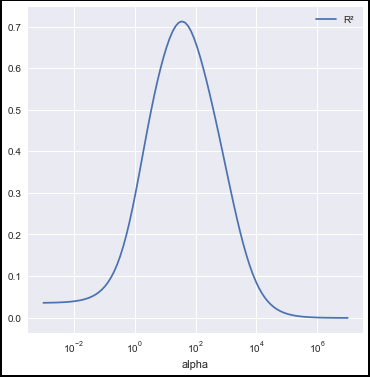

In [158]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4, figsize=(6, 6))
plt.plot(liste_alpha, liste_R2)
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R²'])
plt.show()

#### Plot du R² en fonction de max_samples

In [159]:
liste_x = np.linspace(0.01, 1, 100)
liste_R2 = []
for x in liste_x:
    bag_reg_test = BaggingRegressor(base_estimator=Ridge(alpha=46),
                                    bootstrap=True,
                                    max_samples=x,
                                    max_features=1.0,
                                    n_estimators=10,
                                    n_jobs=7,
                                    random_state=0)
    scores = cross_val_score(bag_reg_test,
                             X_train_GHG_ss,
                             y_train_GHG.iloc[:, 0],
                             scoring="r2",
                             cv=5)
    liste_R2.append(scores.mean())

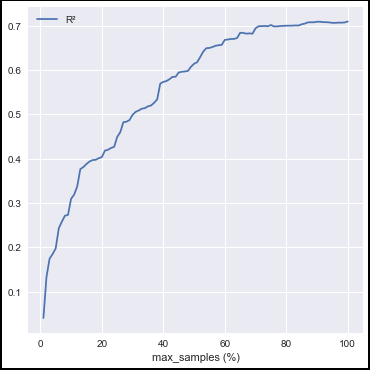

In [160]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4, figsize=(6, 6))
plt.plot([x*100 for x in liste_x], liste_R2)
plt.xlabel('max_samples (%)')
plt.legend(['R²'])
plt.show()

#### Plot du R² en fonction de max_features

In [161]:
liste_x = np.linspace(0.01, 1, 100)
liste_R2 = []
for x in liste_x:
    bag_reg_test = BaggingRegressor(base_estimator=Ridge(alpha=46),
                                    bootstrap=True,
                                    max_samples=1.0,
                                    max_features=x,
                                    n_estimators=10,
                                    n_jobs=7,
                                    random_state=0)
    scores = cross_val_score(bag_reg_test,
                             X_train_GHG_ss,
                             y_train_GHG.iloc[:, 0],
                             scoring="r2",
                             cv=5)
    liste_R2.append(scores.mean())

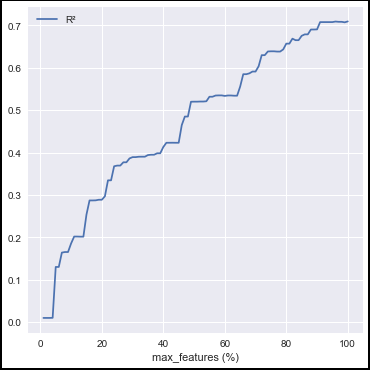

In [162]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4, figsize=(6, 6))
plt.plot([x*100 for x in liste_x], liste_R2)
plt.xlabel('max_features (%)')
plt.legend(['R²'])
plt.show()

#### Plot du R² en fonction de n_estimators

In [163]:
liste_x = np.arange(1, 40)
liste_R2 = []
for x in liste_x:
    bag_reg_test = BaggingRegressor(base_estimator=Ridge(alpha=46),
                                    bootstrap=True,
                                    max_samples=1.0,
                                    max_features=1.0,
                                    n_estimators=x,
                                    n_jobs=7,
                                    random_state=0)
    scores = cross_val_score(bag_reg_test,
                             X_train_GHG_ss,
                             y_train_GHG.iloc[:, 0],
                             scoring="r2",
                             cv=5)
    liste_R2.append(scores.mean())

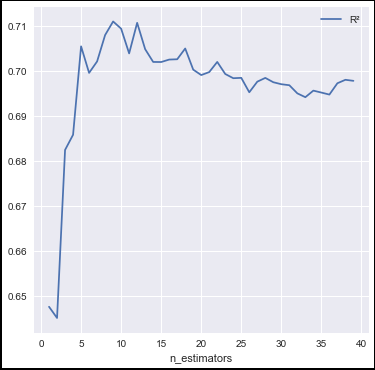

In [164]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4, figsize=(6, 6))
plt.plot(liste_x, liste_R2)
plt.xlabel('n_estimators')
plt.legend(['R²'])
plt.show()

#### Généralisation sur le test set

In [165]:
GHG_predictions = grid_search.predict(X_test_GHG_ss)
R2_ss_bag_ridge_pred = r2_score(y_test_GHG, GHG_predictions)
print("R² (pour généralisation du modèle retenu) =", arrondi(R2_ss_bag_ridge_pred))

R² (pour généralisation du modèle retenu) = 0.903


##### Scatter plot : Prédictions = f(Observations)

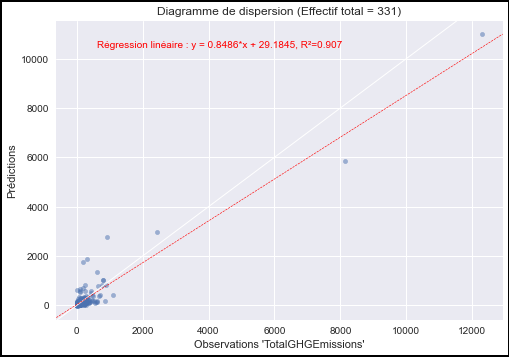

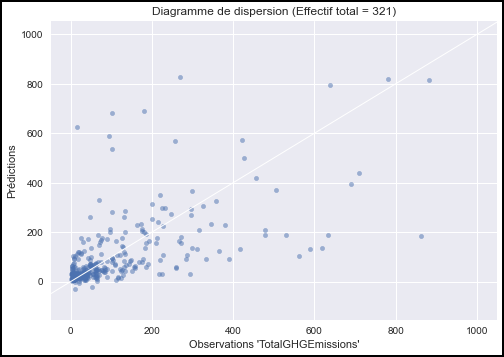

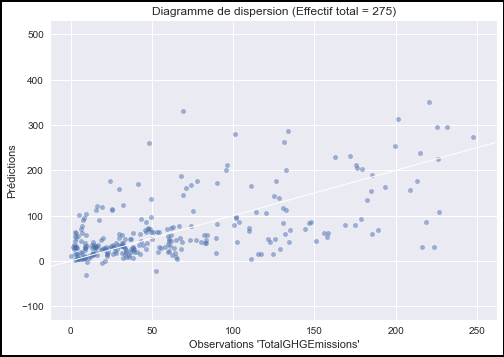

In [166]:
# Données du testing set :
ser_predictions = pd.Series(np.squeeze(GHG_predictions), name='Prédictions')
ser_x = y_test_GHG.reset_index().iloc[:,1]
ser_x.name = "Observations 'TotalGHGEmissions'"
scatter_plot(ser_x, ser_y=ser_predictions, alpha=0.5, taille=20, droite_identite=True)
scatter_plot(ser_x, ser_y=ser_predictions, alpha=0.5, taille=20, max_x=1000, min_y=-100, max_y=1000, droite_identite=True, regression_lineaire=False)
scatter_plot(ser_x, ser_y=ser_predictions, alpha=0.5, taille=20, max_x=250, min_y=-100, max_y=500, droite_identite=True, regression_lineaire=False)

##### Scatter plot : Prédictions-Observations = f(Observations)

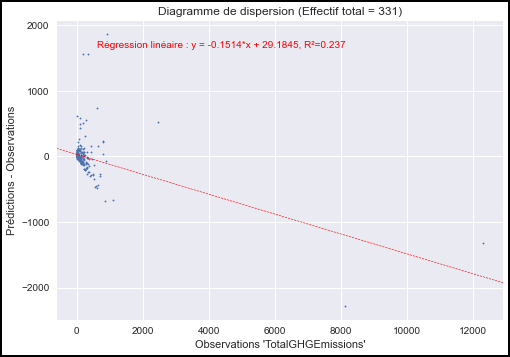

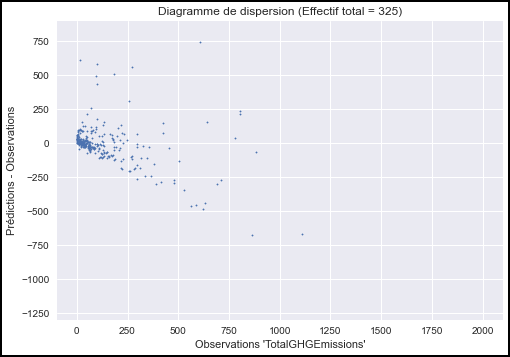

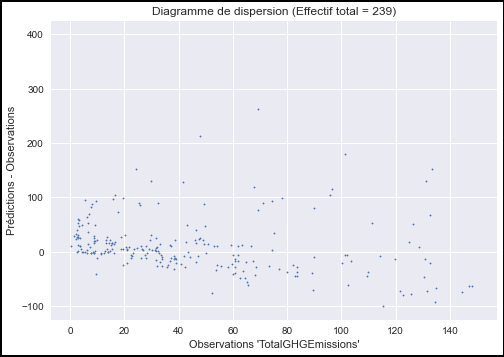

In [167]:
ser_predictions = pd.Series(np.squeeze(GHG_predictions), name='Prédictions')
ser_predictions_moins_mesures = ser_predictions - y_test_GHG.reset_index().iloc[:,1]
ser_predictions_moins_mesures.name = 'Prédictions - Observations'
ser_x = y_test_GHG.reset_index().iloc[:,1]
ser_x.name = "Observations 'TotalGHGEmissions'"
scatter_plot(ser_x, ser_y=ser_predictions_moins_mesures, alpha=1)
scatter_plot(ser_x, ser_y=ser_predictions_moins_mesures, alpha=1, max_x=2000, min_y=-1200, max_y=800, regression_lineaire=False)
scatter_plot(ser_x, ser_y=ser_predictions_moins_mesures, alpha=1, max_x=150, min_y=-100, max_y=400, regression_lineaire=False)

#### Cohérence du train set

In [168]:
GHG_predictions = grid_search.predict(X_train_GHG_ss)
R2_ss_bag_ridge_pred_train = r2_score(y_train_GHG, GHG_predictions)
print("R² (sur le train set) =", arrondi(R2_ss_bag_ridge_pred_train))

R² (sur le train set) = 0.86


##### Scatter plot : Prédictions = f(Observations)

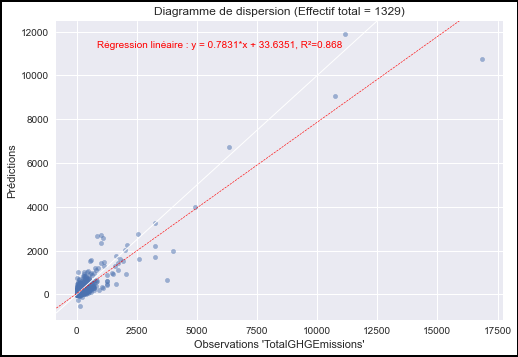

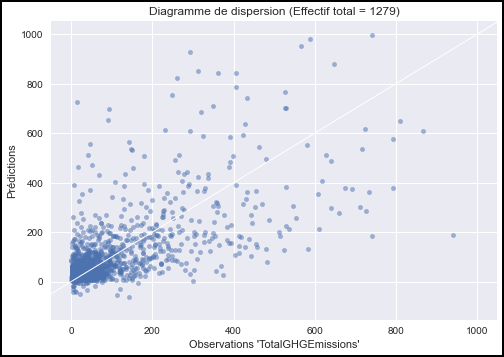

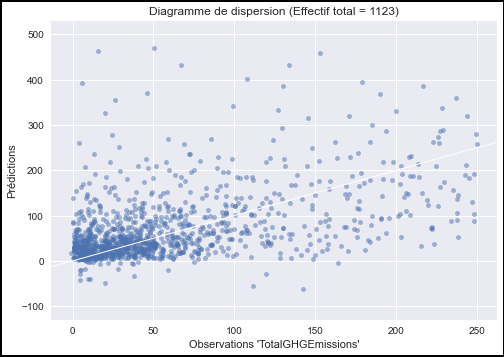

In [169]:
# Données du testing set :
ser_predictions = pd.Series(np.squeeze(GHG_predictions), name='Prédictions')
ser_x = y_train_GHG.reset_index().iloc[:,1]
ser_x.name = "Observations 'TotalGHGEmissions'"
scatter_plot(ser_x, ser_y=ser_predictions, alpha=0.5, taille=20, droite_identite=True)
scatter_plot(ser_x, ser_y=ser_predictions, alpha=0.5, taille=20, max_x=1000, min_y=-100, max_y=1000, droite_identite=True, regression_lineaire=False)
scatter_plot(ser_x, ser_y=ser_predictions, alpha=0.5, taille=20, max_x=250, min_y=-100, max_y=500, droite_identite=True, regression_lineaire=False)

### Régularisation régression Lasso avec data normalisée par StandardScaler

##### GridSearchCV à une dimension :

In [170]:
bag_reg = BaggingRegressor(base_estimator=Lasso(alpha=1), max_samples=1.0, n_jobs=7, random_state=0)
param_grid = [
    {'base_estimator__alpha': np.logspace(-4, 2, 10)}, 
    {'max_samples': [0.25, 0.5, 0.75, 0.9, 1.0]}, 
    {'max_features': [0.125, 0.25, 0.5, 0.75, 1.0]},
    {'n_estimators': [8, 16, 32, 64, 128]}]
grid_search = GridSearchCV(bag_reg,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=7)
grid_search.fit(X_train_GHG_ss, y_train_GHG.iloc[:, 0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1), n_jobs=7,
                                        random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__alpha': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00, 2.15443469e+01,
       1.00000000e+02])},
                         {'max_samples': [0.25, 0.5, 0.75, 0.9, 1.0]},
                         {'max_features': [0.125, 0.25, 0.5, 0.75, 1.0]},
                         {'n_estimators': [8, 16, 32, 64, 128]}],
             return_train_score=True, scoring='r2')

In [171]:
grid_search.best_params_

{'max_samples': 0.5}

In [172]:
arrondi(grid_search.best_score_)

0.667

In [173]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", str(arrondi(mean_score)).rjust(8, ' '), params)

R² =    0.035 {'base_estimator__alpha': 0.0001}
R² =   0.0352 {'base_estimator__alpha': 0.00046415888336127773}
R² =    0.036 {'base_estimator__alpha': 0.002154434690031882}
R² =   0.0399 {'base_estimator__alpha': 0.01}
R² =   0.0576 {'base_estimator__alpha': 0.046415888336127774}
R² =    0.118 {'base_estimator__alpha': 0.21544346900318823}
R² =    0.321 {'base_estimator__alpha': 1.0}
R² =     0.65 {'base_estimator__alpha': 4.641588833612772}
R² =    0.575 {'base_estimator__alpha': 21.54434690031882}
R² =    0.286 {'base_estimator__alpha': 100.0}
R² =    0.599 {'max_samples': 0.25}
R² =    0.667 {'max_samples': 0.5}
R² =    0.147 {'max_samples': 0.75}
R² =    0.275 {'max_samples': 0.9}
R² =    0.321 {'max_samples': 1.0}
R² =    0.233 {'max_features': 0.125}
R² =    0.426 {'max_features': 0.25}
R² =    0.586 {'max_features': 0.5}
R² =    0.601 {'max_features': 0.75}
R² =    0.321 {'max_features': 1.0}
R² =    0.153 {'n_estimators': 8}
R² =    0.271 {'n_estimators': 16}
R² =    0.493 {'n

##### GridSearchCV à plusieurs dimensions :

In [174]:
param_grid = [
    {'base_estimator__alpha': np.logspace(-1, 3, 10),
    'max_samples': [0.5, 0.75, 1.0], 
    'max_features': [0.75, 1.0],
    'n_estimators': [8, 16, 32, 64, 128]}]

grid_search = GridSearchCV(bag_reg, param_grid, cv=5,
                           scoring='r2', return_train_score=True, n_jobs=7)
grid_search.fit(X_train_GHG_ss, y_train_GHG.iloc[:,0])

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1), n_jobs=7,
                                        random_state=0),
             n_jobs=7,
             param_grid=[{'base_estimator__alpha': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00, 5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02, 3.59381366e+02,
       1.00000000e+03]),
                          'max_features': [0.75, 1.0],
                          'max_samples': [0.5, 0.75, 1.0],
                          'n_estimators': [8, 16, 32, 64, 128]}],
             return_train_score=True, scoring='r2')

In [175]:
R2_ss_bag_lasso_cv = grid_search.best_score_
arrondi(R2_ss_bag_lasso_cv)

0.688

In [176]:
affichage_tri_r2(grid_search.cv_results_)

R² =    0.688 {'base_estimator__alpha': 5.994842503189409, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.687 {'base_estimator__alpha': 2.1544346900318834, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 16}
R² =    0.684 {'base_estimator__alpha': 5.994842503189409, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 128}
R² =    0.684 {'base_estimator__alpha': 5.994842503189409, 'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 128}
R² =     0.68 {'base_estimator__alpha': 5.994842503189409, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 32}
R² =     0.68 {'base_estimator__alpha': 5.994842503189409, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 64}
R² =    0.679 {'base_estimator__alpha': 5.994842503189409, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 128}
R² =    0.679 {'base_estimator__alpha': 5.994842503189409, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 64}
R² =    0.678 {'base_estimator__alp

##### Généralisation sur le test set

In [177]:
GHG_predictions = grid_search.predict(X_test_GHG_ss)
R2_ss_bag_lasso_pred = r2_score(y_test_GHG, GHG_predictions)
print("R² =", arrondi(R2_ss_bag_lasso_pred))

R² = 0.905


### Résultats des cross-validations des baggings de modèles linéaires sur le training set

Les scores de CV sur le training sont les suivants :  
- R² = {{arrondi(R2_nr_bag_LR_cv)}} (regression linéaire simple, sans recalibrage des data).
- R² = {{arrondi(R2_nr_bag_ridge_cv)}} Ridge sans recalibrage.
- **R² = {{arrondi(R2_ss_bag_ridge_cv)}} Ridge avec recalibrage StandardScaler.**
- R² = {{arrondi(R2_ss_bag_lasso_cv)}} Lasso avec recalibrage StandardScaler.

### Résultats des généralisations des baggings de modèles linéaires sur le testing set

Après généralisation sur le testing set, les scores obtenus sont : 
- R² = {{arrondi(R2_nr_bag_LR_pred)}} (regression linéaire simple, sans recalibrage des data).
- R² = {{arrondi(R2_nr_bag_ridge_pred)}} (Ridge sans recalibrage).
- R² = {{arrondi(R2_ss_bag_ridge_pred)}} (Ridge avec recalibrage StandardScaler).
- R² = {{arrondi(R2_ss_bag_lasso_pred)}} (Lasso avec recalibrage StandardScaler).